<a href="https://colab.research.google.com/github/chizkidd/mnielsen-neural-networks-and-deep-learning/blob/main/003_mnist_optimization_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
This notebook is inspired by [Chapter 3](http://neuralnetworksanddeeplearning.com/chap3.html) in Michael Nielsen's book [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/index.html)
- <u>Chapter 3: **Improving the Way Neural Networks Learn**</u><br>
The techniques we'll develop in this chapter include:
  - Cross-Entropy cost function
  - Regularization methods
    - L1
    - L2
    - Dropout
    - Artificial expansion of the training data
  - Weight Initialization
  - A set of heuristics to help choose good hyper-parameters
  - Several other techniques covered in less depth.
    - Variations of Stochastic Gradient Descent (SGD)
    - Other models of artificial neuron
  
The discussions are largely independent of one another, and so you may jump ahead if you wish.

---

In [ ]:
import pandas as pd
import torch
import numpy as np
import random
import time, timeit

In [ ]:
# @title
"""network2.py
~~~~~~~~~~~~~~

An improved version of network.py, implementing the stochastic
gradient descent learning algorithm for a feedforward neural network.
Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.  Note
that I have focused on making the code simple, easily readable, and
easily modifiable.  It is not optimized, and omits many desirable
features.

"""

#### Libraries
# Standard library
import json
import random
import sys

# Third-party libraries
import numpy as np


#### Define the quadratic and cross-entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)


class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)


#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """
        if evaluation_data: n_data = len(list(evaluation_data))
        n = len(list(training_data))
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete" % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()


In [ ]:
# @title
#### Loading a Network
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

#### Miscellaneous functions
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [ ]:
# @title
"""network2mat.py
~~~~~~~~~~~~~~

An improved version of network2.py, to perform fully matrix-based
backpropagation. This version avoids the loop over each training
example by using matrix operations on the entire mini-batch.

"""

#### Main Network class
class Network2mat(object):

    def __init__(self, sizes, cost=CrossEntropyCost, reg='l2'):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
        self.reg = reg

    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):

        if evaluation_data: n_data = len(list(evaluation_data))
        n = len(list(training_data))
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete" % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient descent
        using backpropagation to a single mini-batch."""

        # Convert the mini-batch into matrix form
        X = np.column_stack([x for x, y in mini_batch])
        Y = np.column_stack([y for x, y in mini_batch])

        # Perform forward and backward passes
        nabla_b, nabla_w = self.backprop_matrix(X, Y)

        # Update weights and biases using gradient descent and L1 or L2 regularization
        if self.reg == 'l2':
          self.weights = [(1 - eta * (lmbda/n)) * w - (eta/len(mini_batch)) * nw
                          for w, nw in zip(self.weights, nabla_w)]
        elif self.reg == 'l1':
          self.weights = [w - (eta * (lmbda/n)) * np.sign(w) - (eta / len(mini_batch)) * nw
                          for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                      for b, nb in zip(self.biases, nabla_b)]


    def backprop_matrix(self, X, Y):
        """Matrix-based backpropagation for a mini-batch."""

        # Initialize gradients
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Step 1: Forward pass
        activation = X
        activations = [X]  # Store all activations layer by layer
        zs = []  # Store all z vectors layer by layer

        # Feedforward step through all layers
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # Step 2: Backward pass

        # Compute delta at the output layer
        delta = self.cost.delta(zs[-1], activations[-1], Y)

        # Gradients for the output layer
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate through previous layers
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, activations[-l-1].T)

        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        if self.reg == 'l2':
          cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        elif self.reg == 'l1':
          cost += (lmbda/len(data))*sum(np.linalg.norm(w, ord=1) for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

In [ ]:
# !pip install mnist

In [ ]:
import mnist_loader

# Load data
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

# Convert data to lists
training_data = list(training_data)
test_data = list(test_data)

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")


Using cpu device


In [ ]:
%%time
# Initialize and train network
net = Network2mat([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 30, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9183 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9265 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9364 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9413 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9470 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9458 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9498 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9476 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9513 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9496 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9500 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9517 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9482 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9503 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9183,
  9265,
  9364,
  9413,
  9470,
  9458,
  9498,
  9476,
  9513,
  9496,
  9500,
  9517,
  9482,
  9503,
  9532,
  9525,
  9560,
  9541,
  9515,
  9540,
  9536,
  9547,
  9507,
  9530,
  9546,
  9538,
  9551,
  9528,
  9544,
  9550],
 [],
 [])

## ----------------------------------------------------------------------------
## Baseline Backprop (`n_hidden = 30`): **`94.96%`** Accuracy
## Fully Matrix-Based Backprop (`n_hidden = 30`): **`95.50%`** Accuracy

In [ ]:
# %%time
# net = Network([784, 100, 10], cost=CrossEntropyCost)
# net.large_weight_initializer()
# net.SGD(training_data, 30, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

## Baseline Backprop (`n_hidden = 100`): **`96.51%`** Accuracy

In [ ]:
%%time
net = Network2mat([784, 100, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 30, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9179 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9435 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9474 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9555 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9543 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9589 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9588 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9614 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9627 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9642 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9633 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9655 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9654 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9652 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9179,
  9435,
  9474,
  9555,
  9543,
  9589,
  9588,
  9614,
  9627,
  9642,
  9633,
  9655,
  9654,
  9652,
  9626,
  9650,
  9655,
  9654,
  9681,
  9666,
  9645,
  9661,
  9665,
  9678,
  9667,
  9675,
  9669,
  9674,
  9674,
  9679],
 [],
 [])

## Fully Matrix-Based Backprop (`n_hidden` = 100): **`96.79%`** Accuracy

----
# Overfitting



---

The Nobel prizewinning physicist Enrico Fermi was once asked his opinion of a mathematical model some colleagues had proposed as the solution to an important unsolved physics problem. The model gave excellent agreement with experiment, but Fermi was skeptical. He asked how many free parameters could be set in the model. "Four" was the answer. Fermi replied**[1]**: "I remember my friend Johnny von Neumann used to say, with four parameters I can fit an elephant, and with five I can make him wiggle his trunk."
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
1. _The quote comes from a [charming article](https://www.nature.com/articles/427297a) by Freeman Dyson, who is one of the people who proposed the flawed model. A four-parameter elephant may be found [here](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/)._

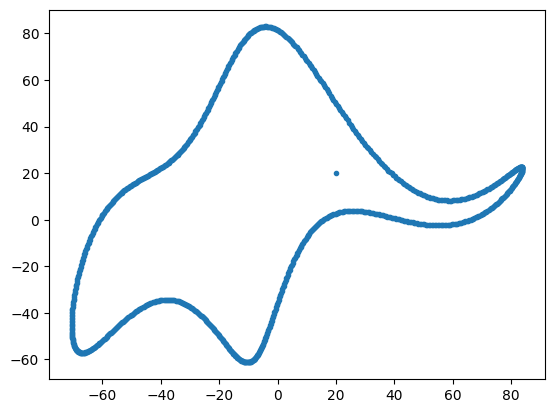

In [ ]:

"""
Author: Piotr A. Zolnierczuk (zolnierczukp at ornl dot gov)
URL: https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/

Based on a paper by:
Drawing an elephant with four complex parameters
Jurgen Mayer, Khaled Khairy, and Jonathon Howard,
Am. J. Phys. 78, 648 (2010), DOI:10.1119/1.3254017
"""
import numpy as np
import pylab

# elephant parameters
p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    x = np.append(fourier(t,Cx), [-p5.imag])
    y = np.append(fourier(t,Cy), [p5.imag])

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,1000), p1, p2, p3, p4, p5)
pylab.plot(y,-x,'.')
pylab.show()

----
The point, of course, is that models with a large number of free parameters can describe an amazingly wide range of phenomena. Even if such a model agrees well with the available data, that doesn't make it a good model. It may just mean there's enough freedom in the model that it can describe almost any data set of the given size, without capturing any genuine insights into the underlying phenomenon. When that happens the model will work well for the existing data, but will fail to generalize to new situations. The true test of a model is its ability to make predictions in situations it hasn't been exposed to before.

Fermi and von Neumann were suspicious of models with four parameters. Our 30 hidden neuron network for classifying MNIST digits has nearly 24,000 parameters! That's a lot of parameters. Our 100 hidden neuron network has nearly 80,000 parameters, and state-of-the-art deep neural nets sometimes contain millions or even billions of parameters. Should we trust the results?

Let's sharpen this problem up by constructing a situation where our network does a bad job generalizing to new situations. We'll use our 30 hidden neuron network, with its 23,860 parameters. But we won't train the network using all 50,000 MNIST training images. Instead, we'll use just the first 1,000 training images. Using that restricted set will make the problem with generalization much more evident. We'll train in a similar way to before, using the cross-entropy cost function, with a learning rate of η=0.5 and a mini-batch size of 10. However, we'll train for 400 epochs, a somewhat larger number than before, because we're not using as many training examples. Let's use `Network2mat` to look at the way the cost function changes:

---

In [ ]:
%%time
net = Network2mat([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data[:1000], 400, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True, monitor_training_cost=True)


Epoch 0 training complete
Cost on training data: 2.1334873081011976
Accuracy on evaluation data: 5362 / 10000
Epoch 1 training complete
Cost on training data: 1.6117154896081094
Accuracy on evaluation data: 6508 / 10000
Epoch 2 training complete
Cost on training data: 1.3435858874341642
Accuracy on evaluation data: 6996 / 10000
Epoch 3 training complete
Cost on training data: 1.118955170706648
Accuracy on evaluation data: 7367 / 10000
Epoch 4 training complete
Cost on training data: 0.9901307112582952
Accuracy on evaluation data: 7592 / 10000
Epoch 5 training complete
Cost on training data: 0.8519259734137855
Accuracy on evaluation data: 7708 / 10000
Epoch 6 training complete
Cost on training data: 0.7960956201359782
Accuracy on evaluation data: 7752 / 10000
Epoch 7 training complete
Cost on training data: 0.6720702851986642
Accuracy on evaluation data: 7931 / 10000
Epoch 8 training complete
Cost on training data: 0.5998755333945173
Accuracy on evaluation data: 8037 / 10000
Epoch 9 tra

([],
 [5362,
  6508,
  6996,
  7367,
  7592,
  7708,
  7752,
  7931,
  8037,
  8080,
  8136,
  8149,
  8160,
  8255,
  8258,
  8267,
  8277,
  8281,
  8276,
  8293,
  8319,
  8324,
  8324,
  8370,
  8351,
  8344,
  8345,
  8352,
  8348,
  8374,
  8386,
  8360,
  8361,
  8381,
  8365,
  8376,
  8390,
  8399,
  8389,
  8398,
  8382,
  8400,
  8394,
  8398,
  8388,
  8392,
  8400,
  8396,
  8410,
  8402,
  8398,
  8405,
  8403,
  8399,
  8410,
  8401,
  8403,
  8405,
  8410,
  8416,
  8408,
  8411,
  8410,
  8413,
  8404,
  8417,
  8418,
  8417,
  8420,
  8412,
  8411,
  8420,
  8410,
  8421,
  8420,
  8426,
  8410,
  8423,
  8431,
  8421,
  8424,
  8434,
  8433,
  8437,
  8419,
  8435,
  8435,
  8424,
  8435,
  8437,
  8441,
  8441,
  8430,
  8443,
  8448,
  8441,
  8441,
  8437,
  8448,
  8444,
  8447,
  8448,
  8445,
  8443,
  8454,
  8446,
  8446,
  8444,
  8441,
  8446,
  8447,
  8444,
  8449,
  8446,
  8442,
  8443,
  8446,
  8444,
  8447,
  8439,
  8439,
  8447,
  8444,
  8444,
  8

## Overfitting: **`84.64%`** Accuracy

- 1st $1000$ training images out of $50000$ MNIST training images
- $30$ neurons in hidden layer
- $0.5$ learning rate
- mini-batch size of $10$
- train for $400$ epochs

In [ ]:
# @title
"""
overfitting
~~~~~~~~~~~

Plot graphs to illustrate the problem of overfitting.
"""

# Standard library
import json
import random
import sys

# My library
sys.path.append('../src/')
import mnist_loader
# import network2

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np


def main(filename, num_epochs,
         training_cost_xmin=200,
         test_accuracy_xmin=200,
         test_cost_xmin=0,
         training_accuracy_xmin=0,
         training_set_size=1000,
         lmbda=0.0):
    """``filename`` is the name of the file where the results will be
    stored.  ``num_epochs`` is the number of epochs to train for.
    ``training_set_size`` is the number of images to train on.
    ``lmbda`` is the regularization parameter.  The other parameters
    set the epochs at which to start plotting on the x axis.
    """
    run_network(filename, num_epochs, training_set_size, lmbda)
    make_plots(filename, num_epochs,
               training_cost_xmin,
               test_accuracy_xmin,
               test_cost_xmin,
               training_accuracy_xmin,
               training_set_size)

def run_network(filename, num_epochs, training_set_size=1000, lmbda=0.0):
    """Train the network for ``num_epochs`` on ``training_set_size``
    images, and store the results in ``filename``.  Those results can
    later be used by ``make_plots``.  Note that the results are stored
    to disk in large part because it's convenient not to have to
    ``run_network`` each time we want to make a plot (it's slow).

    """
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

    # Convert data to lists
    training_data = list(training_data)
    validation_data = list(validation_data)
    test_data = list(test_data)

    net = Network2mat([784, 30, 10], cost=CrossEntropyCost())
    net.large_weight_initializer()
    test_cost, test_accuracy, training_cost, training_accuracy \
        = net.SGD(training_data[:training_set_size], num_epochs, 10, 0.5,
                  evaluation_data=test_data, lmbda = lmbda,
                  monitor_evaluation_cost=True,
                  monitor_evaluation_accuracy=True,
                  monitor_training_cost=True,
                  monitor_training_accuracy=True)
    f = open(filename, "w")
    json.dump([test_cost, test_accuracy, training_cost, training_accuracy], f)
    f.close()

def make_plots(filename, num_epochs,
               training_cost_xmin=200,
               test_accuracy_xmin=200,
               test_cost_xmin=0,
               training_accuracy_xmin=0,
               training_set_size=1000):
    """Load the results from ``filename``, and generate the corresponding
    plots. """
    f = open(filename, "r")
    test_cost, test_accuracy, training_cost, training_accuracy \
        = json.load(f)
    f.close()
    plot_training_cost(training_cost, num_epochs, training_cost_xmin)
    plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin)
    plot_test_cost(test_cost, num_epochs, test_cost_xmin)
    plot_training_accuracy(training_accuracy, num_epochs,
                           training_accuracy_xmin, training_set_size)
    plot_overlay(test_accuracy, training_accuracy, num_epochs,
                 min(test_accuracy_xmin, training_accuracy_xmin),
                 training_set_size)

def plot_training_cost(training_cost, num_epochs, training_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_cost_xmin, num_epochs),
            training_cost[training_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([training_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the training data')
    plt.show()

def plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_accuracy_xmin, num_epochs),
            [accuracy/100.0
             for accuracy in test_accuracy[test_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([test_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the test data')
    plt.show()

def plot_test_cost(test_cost, num_epochs, test_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_cost_xmin, num_epochs),
            test_cost[test_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([test_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the test data')
    plt.show()

def plot_training_accuracy(training_accuracy, num_epochs,
                           training_accuracy_xmin, training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_accuracy_xmin, num_epochs),
            [accuracy*100.0/training_set_size
             for accuracy in training_accuracy[training_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([training_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the training data')
    plt.show()

def plot_overlay(test_accuracy, training_accuracy, num_epochs, xmin,
                 training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(xmin, num_epochs),
            [accuracy/100.0 for accuracy in test_accuracy],
            color='#2A6EA6',
            label="Accuracy on the test data")
    ax.plot(np.arange(xmin, num_epochs),
            [accuracy*100.0/training_set_size
             for accuracy in training_accuracy],
            color='#FFA933',
            label="Accuracy on the training data")
    ax.grid(True)
    ax.set_xlim([xmin, num_epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylim([90, 100])
    plt.legend(loc="lower right")
    plt.show()


Enter a file name: train1000-2
Enter the number of epochs to run for: 400
training_cost_xmin (suggest 200): 200
test_accuracy_xmin (suggest 200): 200
test_cost_xmin (suggest 0): 0
training_accuracy_xmin (suggest 0): 0
Training set size (suggest 1000): 1000
Enter the regularization parameter, lambda (suggest: 5.0): 0
Epoch 0 training complete
Cost on training data: 1.9075988236669716
Accuracy on training data: 654 / 1000
Cost on evaluation data: 2.15247583066795
Accuracy on evaluation data: 5689 / 10000
Epoch 1 training complete
Cost on training data: 1.3963045571853507
Accuracy on training data: 780 / 1000
Cost on evaluation data: 1.7751670577479657
Accuracy on evaluation data: 6621 / 10000
Epoch 2 training complete
Cost on training data: 1.1861623435401252
Accuracy on training data: 803 / 1000
Cost on evaluation data: 1.5886885172771115
Accuracy on evaluation data: 6936 / 10000
Epoch 3 training complete
Cost on training data: 0.957877685241931
Accuracy on training data: 863 / 1000
Cos

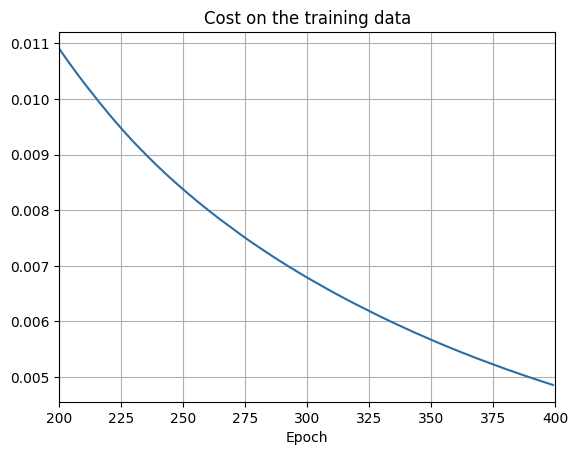

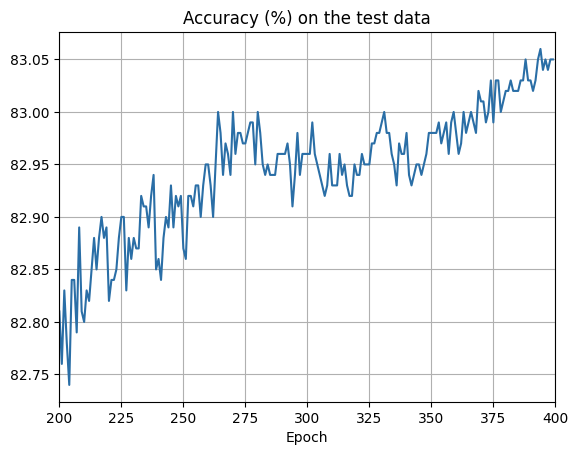

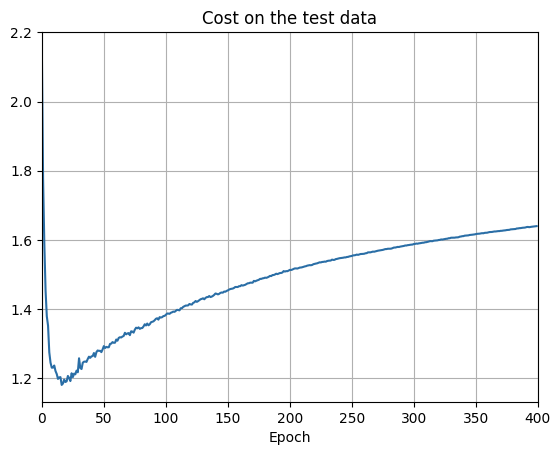

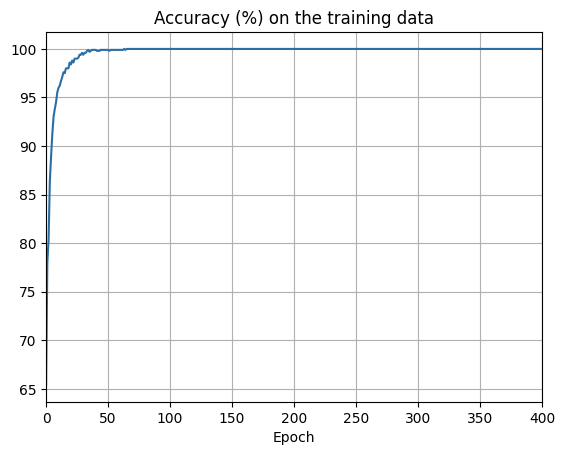

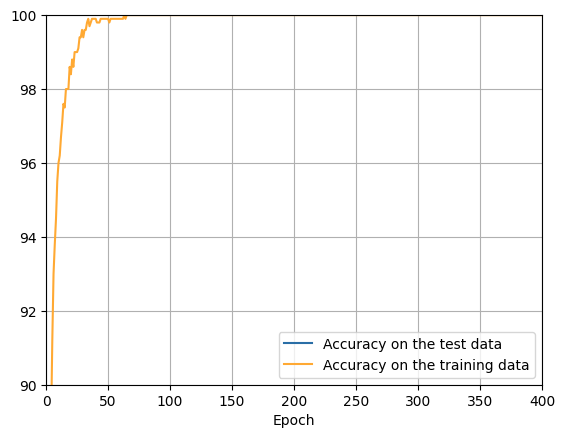

CPU times: user 14min 38s, sys: 11min 39s, total: 26min 17s
Wall time: 15min 50s


In [ ]:
# @title
%%time
if __name__ == "__main__":
    filename = input("Enter a file name: ")
    num_epochs = int(input("Enter the number of epochs to run for: "))
    training_cost_xmin = int(input("training_cost_xmin (suggest 200): "))
    test_accuracy_xmin = int(input("test_accuracy_xmin (suggest 200): "))
    test_cost_xmin = int(input("test_cost_xmin (suggest 0): "))
    training_accuracy_xmin = int(input("training_accuracy_xmin (suggest 0): "))
    training_set_size = int(input("Training set size (suggest 1000): "))
    lmbda = float(input("Enter the regularization parameter, lambda (suggest: 5.0): "))
    main(filename, num_epochs, training_cost_xmin,
         test_accuracy_xmin, test_cost_xmin, training_accuracy_xmin,
         training_set_size, lmbda)

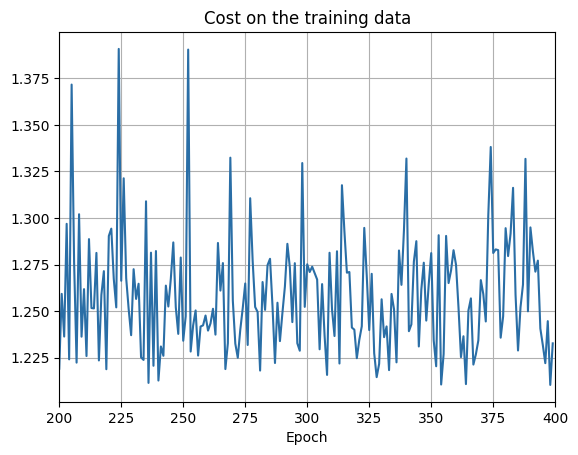

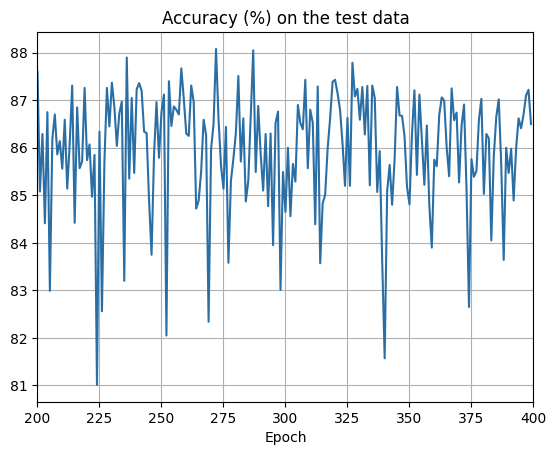

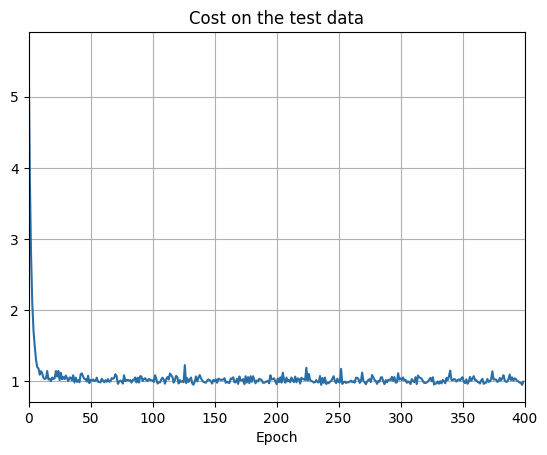

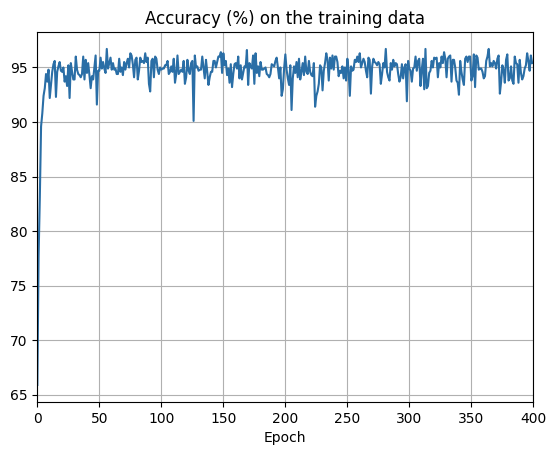

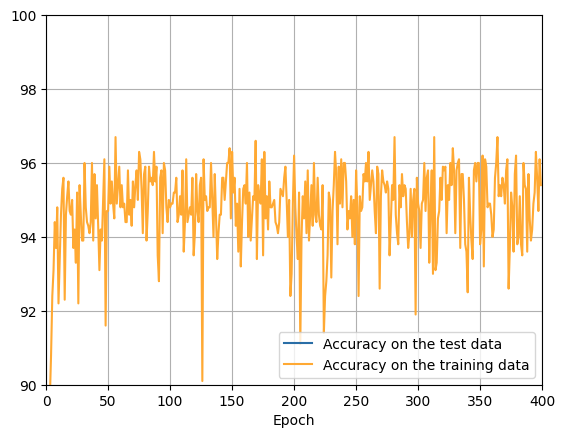

In [ ]:
training_cost_xmin=200
test_accuracy_xmin=200
test_cost_xmin=0
training_accuracy_xmin=0
training_set_size=1000
lmbda=5.0

# local filename: train1000-lamdba5
make_plots('/content/train1000', 400,
               training_cost_xmin,
               test_accuracy_xmin,
               test_cost_xmin,
               training_accuracy_xmin,
               training_set_size)

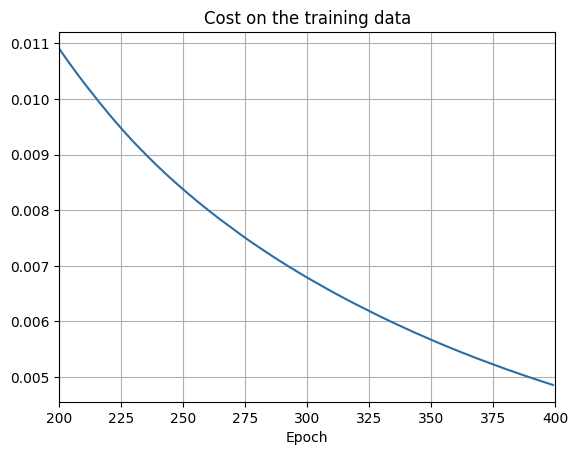

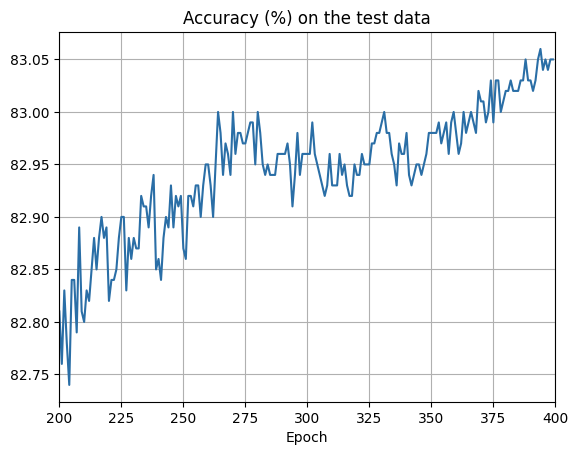

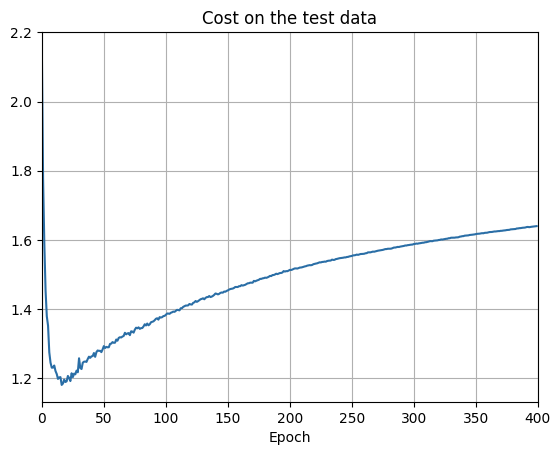

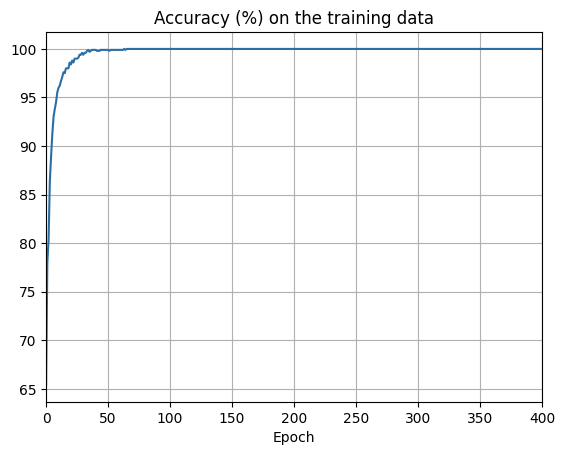

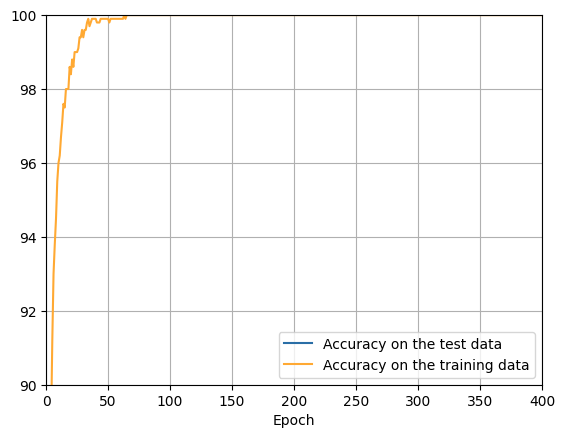

In [ ]:
training_cost_xmin=200
test_accuracy_xmin=200
test_cost_xmin=0
training_accuracy_xmin=0
training_set_size=1000
lmbda=0.0

# local filename: train1000
make_plots('/content/train1000-2', 400,
               training_cost_xmin,
               test_accuracy_xmin,
               test_cost_xmin,
               training_accuracy_xmin,
               training_set_size)

----
 - training accuracy: **100%**
 - test accuracy: **83.05%**
 - training acc - test acc: **16.95%**
 ----

Enter a file name: train50000
Enter the number of epochs to run for: 30
training_cost_xmin (suggest 200): 15
test_accuracy_xmin (suggest 200): 15
test_cost_xmin (suggest 0): 0
training_accuracy_xmin (suggest 0): 0
Training set size (suggest 1000): 50000
Enter the regularization parameter, lambda (suggest: 5.0): 0
Epoch 0 training complete
Cost on training data: 0.565487411645113
Accuracy on training data: 45774 / 50000
Cost on evaluation data: 0.5623484668671077
Accuracy on evaluation data: 9147 / 10000
Epoch 1 training complete
Cost on training data: 0.4743487323018099
Accuracy on training data: 46415 / 50000
Cost on evaluation data: 0.49780077854652244
Accuracy on evaluation data: 9206 / 10000
Epoch 2 training complete
Cost on training data: 0.4241966751129283
Accuracy on training data: 46822 / 50000
Cost on evaluation data: 0.459207819060238
Accuracy on evaluation data: 9303 / 10000
Epoch 3 training complete
Cost on training data: 0.37634258350749356
Accuracy on training data: 47143

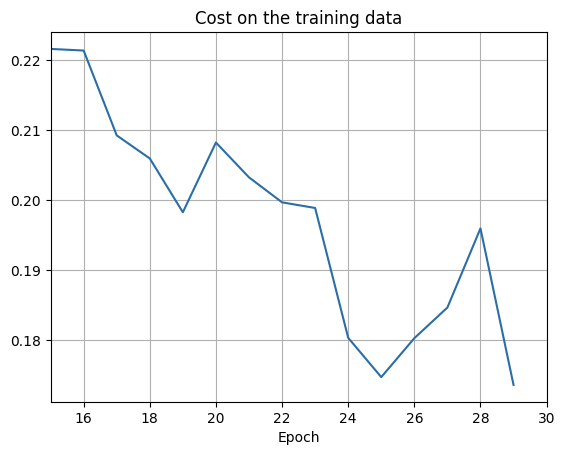

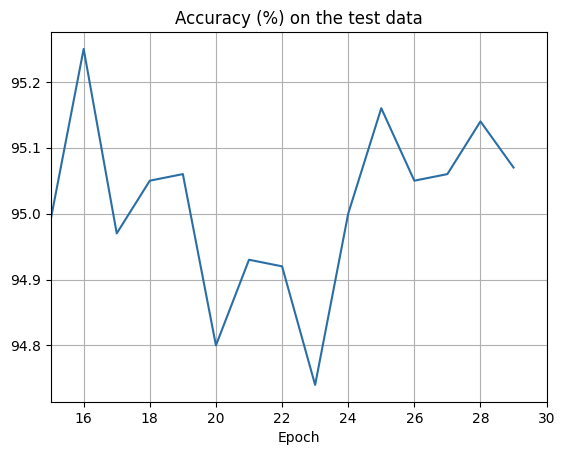

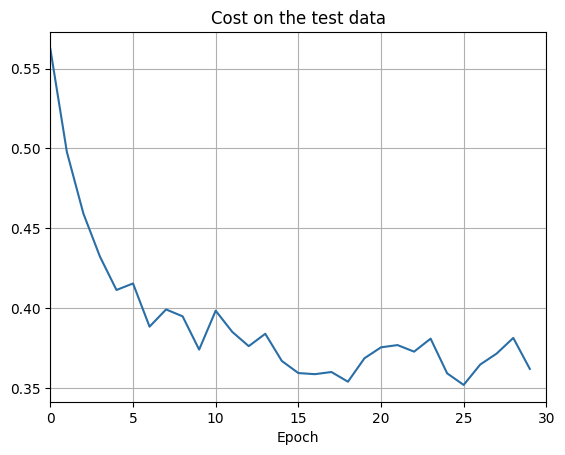

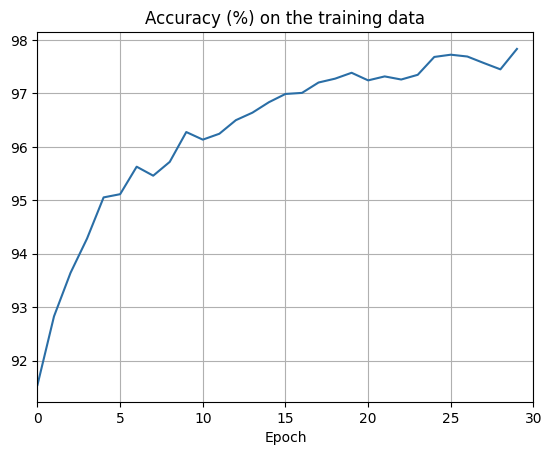

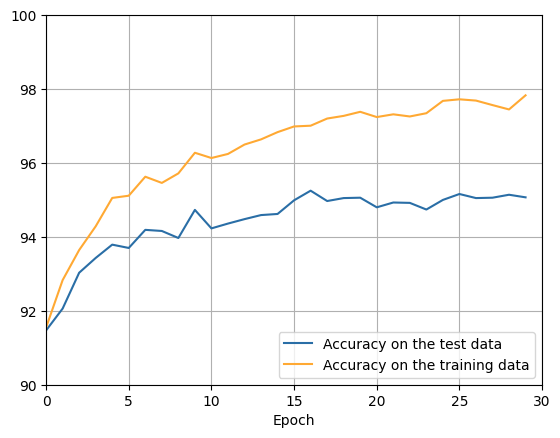

CPU times: user 5min 53s, sys: 3min 57s, total: 9min 50s
Wall time: 7min 41s


In [ ]:
%%time
if __name__ == "__main__":
    filename = input("Enter a file name: ")
    num_epochs = int(input("Enter the number of epochs to run for: "))
    training_cost_xmin = int(input("training_cost_xmin (suggest 200): "))
    test_accuracy_xmin = int(input("test_accuracy_xmin (suggest 200): "))
    test_cost_xmin = int(input("test_cost_xmin (suggest 0): "))
    training_accuracy_xmin = int(input("training_accuracy_xmin (suggest 0): "))
    training_set_size = int(input("Training set size (suggest 1000): "))
    lmbda = float(input("Enter the regularization parameter, lambda (suggest: 5.0): "))
    main(filename, num_epochs, training_cost_xmin,
         test_accuracy_xmin, test_cost_xmin, training_accuracy_xmin,
         training_set_size, lmbda)

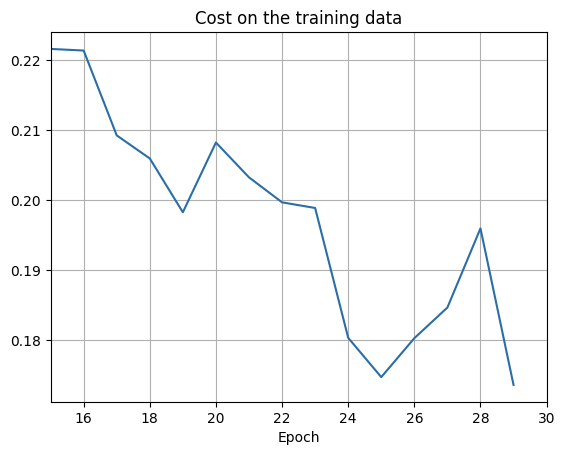

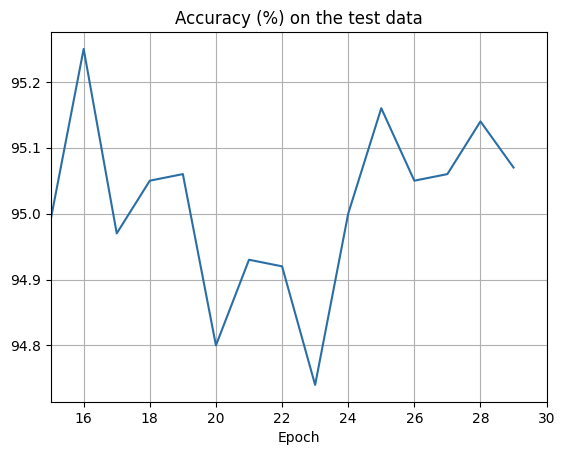

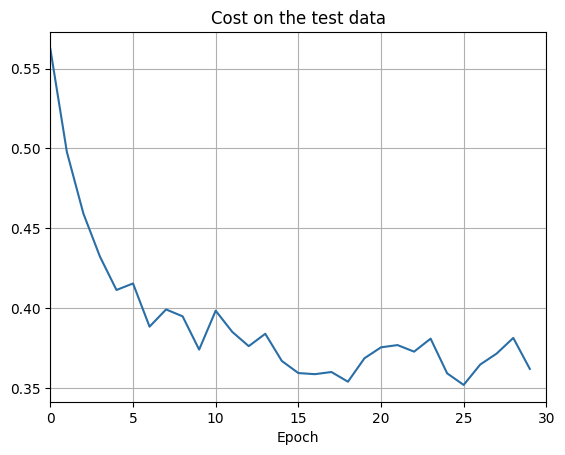

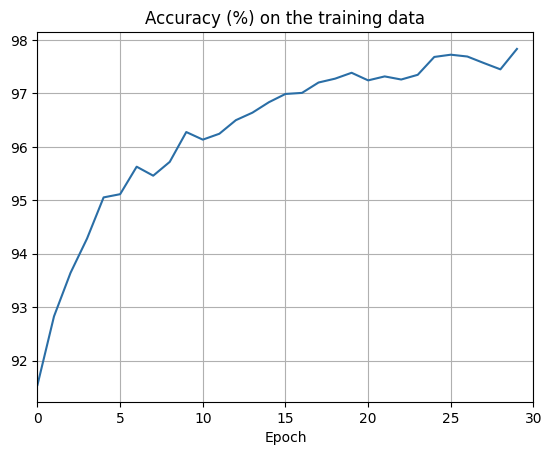

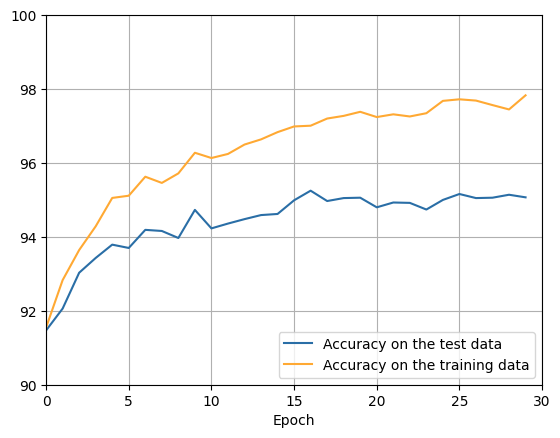

In [ ]:
training_cost_xmin=15
test_accuracy_xmin=15
test_cost_xmin=0
training_accuracy_xmin=0
training_set_size=50000
lmbda=0.0

make_plots('/content/train50000', 30,
               training_cost_xmin,
               test_accuracy_xmin,
               test_cost_xmin,
               training_accuracy_xmin,
               training_set_size)

----
 - training accuracy: **97.83%**
 - test accuracy: **95.07%**
 - training acc $-$ test acc: **2.76%**


 A **2.76%** gap exists between the training and test accuracy compared to the **16.95%** gap earlier. Overfitting is still going on, but it's been greatly reduced. Our network is generalizing much better from the training data to the test data. In general, one of the best ways of reducing overfitting is to increase the size of the training data. With enough training data it is difficult for even a very large network to overfit. Unfortunately, training data can be expensive or difficult to acquire, so this is not always a practical option.
 <a id="eqn1"></a>
 ---

----
# Regularization



---

Increasing the amount of training data is one way of reducing overfitting. Are there other ways we can reduce the extent to which overfitting occurs? One possible approach is to reduce the size of our network. However, large networks have the potential to be more powerful than small networks, and so this is an option we'd only adopt reluctantly.

Fortunately, there are other techniques which can reduce overfitting, even when we have a fixed network and fixed training data. These are known as regularization techniques. In this section I describe one of the most commonly used _**regularization**_ techniques, a technique sometimes known as **weight decay** or **L2 regularization**. The idea of L2 regularization is to add an extra term to the cost function, a term called the **regularization term**. Here's the regularized cross-entropy:


<span id="eqtn1" class="displaced_anchor"></span>
\begin{eqnarray}
C = -\frac{1}{n} \sum_x \sum_j \left[ y_j \ln a^L_j + (1 - y_j) \ln (1 - a^L_j) \right] + \frac{\lambda}{2n} \sum_w w^2.
\tag{1}
\end{eqnarray}

The first term is just the usual expression for the cross-entropy. But
we've added a second term, namely the sum of the squares of all the
weights in the network. This is scaled by a factor $\lambda / 2n$, where
$\lambda > 0$ is known as the ***regularization parameter***, and $n$ is,
as usual, the size of our training set. I'll discuss later how $\lambda$
is chosen. It's also worth noting that the regularization term ***doesn't***
include the biases. I'll also come back to that below.

Of course, it's possible to regularize other cost functions, such as the
quadratic cost. This can be done in a similar way:

<span id="eqtn2" class="displaced_anchor"></span>
\begin{eqnarray}
C = \frac{1}{2n} \sum_x ||y - a^L||^2 + \frac{\lambda}{2n} \sum_w w^2.
\tag{2}
\end{eqnarray}


In both cases we can write the regularized cost function as:

<span id="eqtn3" class="displaced_anchor"></span>
\begin{eqnarray}
C = C_0 + \frac{\lambda}{2n} \sum_w w^2,
\tag{3}
\end{eqnarray}
where $C_0$ is the original, unregularized cost function.

Intuitively, the effect of regularization is to make it so the network
prefers to learn small weights, all other things being equal. Large
weights will only be allowed if they considerably improve the first part
of the cost function. Put another way, regularization can be viewed as a
way of compromising between finding small weights and minimizing the
original cost function. The relative importance of the two elements of
the compromise depends on the value of $\lambda$:
- when $\lambda$ is small we prefer to minimize the original cost function,
- but when $\lambda$ is large we prefer small weights.

Now, it's really not at all obvious why making this kind of compromise
should help reduce overfitting! But it turns out that it does. We'll
address the question of why it helps in the next section. But first,
let's work through an example showing that regularization really does
reduce overfitting.

To construct such an example, we first need to figure out how to apply
our stochastic gradient descent learning algorithm in a regularized
neural network. In particular, we need to know how to compute the
partial derivatives $\partial C / \partial w$ and $\partial C / \partial
b$ for all the weights and biases in the network. Taking the partial
derivatives of **Equation (1)** gives

<span id="eqtn4" class="displaced_anchor"></span>
<span id="eqtn5" class="displaced_anchor"></span>
\begin{eqnarray}
\frac{\partial C}{\partial w} & = & \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} w
\tag{4}\\
\frac{\partial C}{\partial b} & = & \frac{\partial C_0}{\partial b}.
\tag{5}
\end{eqnarray}

The $\partial C_0 / \partial w$ and $\partial C_0 / \partial b$ terms
can be computed using backpropagation, as described in the last chapter**[2]**. And so we see that it's easy to compute the gradient of the regularized cost function: just use backpropagation, as
usual, and then add $\frac{\lambda}{n} w$ to the partial derivative of
all the weight terms. The partial derivatives with respect to the biases
are unchanged, and so the gradient descent learning rule for the biases
doesn't change from the usual rule:

<span id="eqtn6" class="displaced_anchor"></span>
\begin{eqnarray}
b & \rightarrow & b -\eta \frac{\partial C_0}{\partial b}.
\tag{6}
\end{eqnarray}

The learning rule for the weights becomes:

<span id="eqtn7" class="displaced_anchor"></span>
<span id="eqtn8" class="displaced_anchor"></span>
\begin{eqnarray}
w & \rightarrow & w-\eta \frac{\partial C_0}{\partial w}-\frac{\eta\lambda}{n} w
\tag{7}
\\ & = &
\left(1-\frac{\eta \lambda}{n}\right) w -\eta \frac{\partial C_0}{\partial w}. \tag{8}
\end{eqnarray}

This is exactly the same as the usual gradient descent learning rule,
except we first rescale the weight $w$ by a factor $1-\frac{\eta
\lambda}{n}$. This rescaling is sometimes referred to as ***weight decay***,
since it makes the weights smaller. At first glance it looks as though
this means the weights are being driven unstoppably toward zero. But
that's not right, since the other term may lead the weights to increase,
if so doing causes a decrease in the unregularized cost function.

Okay, that's how gradient descent works. What about stochastic gradient
descent? Well, just as in unregularized stochastic gradient descent, we
can estimate $\partial C_0 / \partial w$ by averaging over a mini-batch
of $m$ training examples. Thus the regularized learning rule for
stochastic gradient descent becomes

<span id="eqtn9" class="displaced_anchor"></span>
\begin{eqnarray}
w \rightarrow \left(1-\frac{\eta \lambda}{n}\right) w -\frac{\eta}{m}
\sum_x \frac{\partial C_x}{\partial w},
\tag{9}
\end{eqnarray}

where the sum is over training examples $x$ in the mini-batch, and $C_x$
is the (unregularized) cost for each training example. This is exactly
the same as the usual rule for stochastic gradient descent, except for
the $1-\frac{\eta \lambda}{n}$ weight decay factor. Finally, and for
completeness, let me state the regularized learning rule for the biases.
This is, of course, exactly the same as in the unregularized case

<span id="eqtn10" class="displaced_anchor"></span>
\begin{eqnarray}
b \rightarrow b - \frac{\eta}{m} \sum_x \frac{\partial C_x}{\partial b},
\tag{10}
\end{eqnarray}
where the sum is over training examples $x$ in the mini-batch.

Let's see how regularization changes the performance of our neural
network. We'll use a network with $30$ hidden neurons, a mini-batch size
of $10$, a learning rate of $0.5$, and the cross-entropy cost function.
However, this time we'll use a regularization parameter of $\lambda =
0.1$. Note that in the code, we use the variable name `lmbda`, because
`lambda` is a reserved word in Python, with an unrelated meaning. I've
also used the `test_data` again, not the `validation_data`. Strictly
speaking, we should use the `validation_data`, for all the reasons we
discussed earlier. But I decided to use the `test_data` because it makes
the results more directly comparable with our earlier, unregularized
results. You can easily change the code to use the `validation_data`
instead, and you'll find that it gives similar results.

<br><br><br><br><br><br><br><br><br>  

---
**References:**<br>
2. _[Chapter 2: _How The Backpropagation Algorithm Works._](http://neuralnetworksanddeeplearning.com/chap2.html) Neural Networks and Deep Learning. By Michael Nielsen. Dec 2019._

In [ ]:
# net = Network2mat([784, 30, 10], cost=CrossEntropyCost)
# net.large_weight_initializer()
# net.SGD(training_data[:1000], 400, 10, 0.5,
#         evaluation_data=test_data, lmbda = 0.1,
#         monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
#         monitor_training_cost=True, monitor_training_accuracy=True)

Enter a file name: train1000-lambda_point1
Enter the number of epochs to run for: 400
training_cost_xmin (suggest 200): 200
test_accuracy_xmin (suggest 200): 200
test_cost_xmin (suggest 0): 0
training_accuracy_xmin (suggest 0): 0
Training set size (suggest 1000): 1000
Enter the regularization parameter, lambda (suggest: 5.0): 0.1
Epoch 0 training complete
Cost on training data: 3.070360696676798
Accuracy on training data: 654 / 1000
Cost on evaluation data: 2.267426805451026
Accuracy on evaluation data: 5689 / 10000
Epoch 1 training complete
Cost on training data: 2.5499498812714574
Accuracy on training data: 779 / 1000
Cost on evaluation data: 1.8874601622712677
Accuracy on evaluation data: 6627 / 10000
Epoch 2 training complete
Cost on training data: 2.3300385720251486
Accuracy on training data: 801 / 1000
Cost on evaluation data: 1.6980853395461923
Accuracy on evaluation data: 6951 / 10000
Epoch 3 training complete
Cost on training data: 2.09308027964456
Accuracy on training data: 8

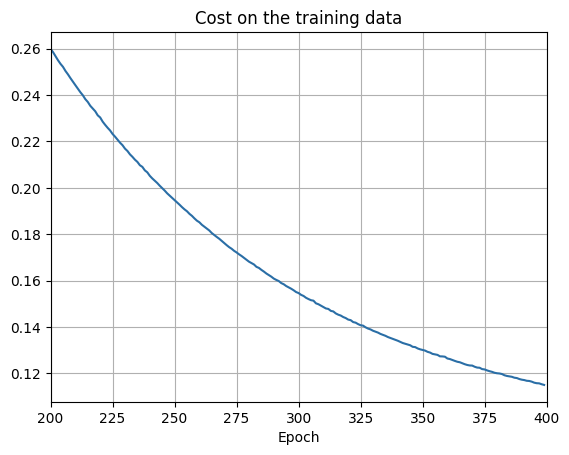

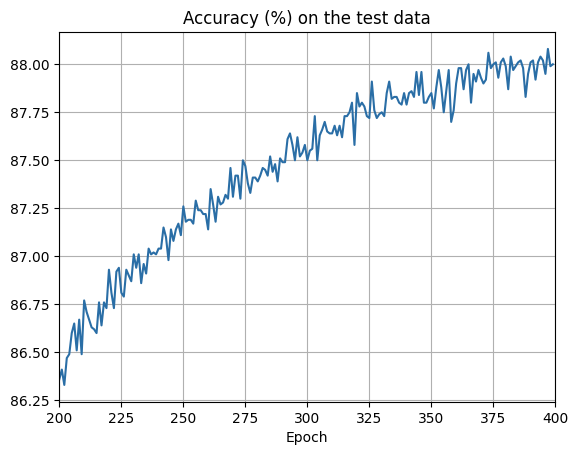

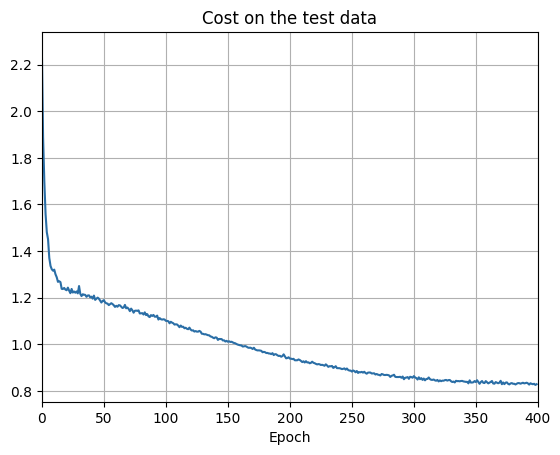

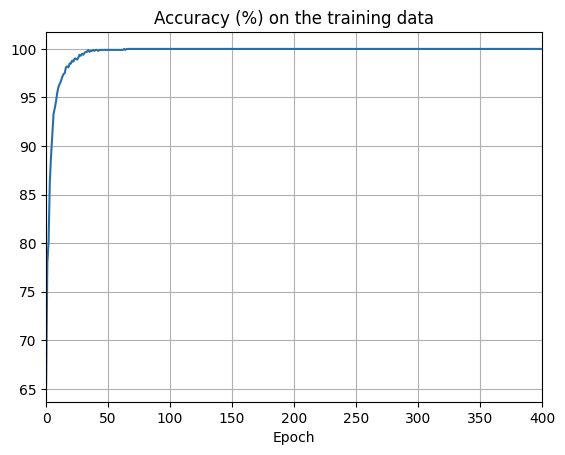

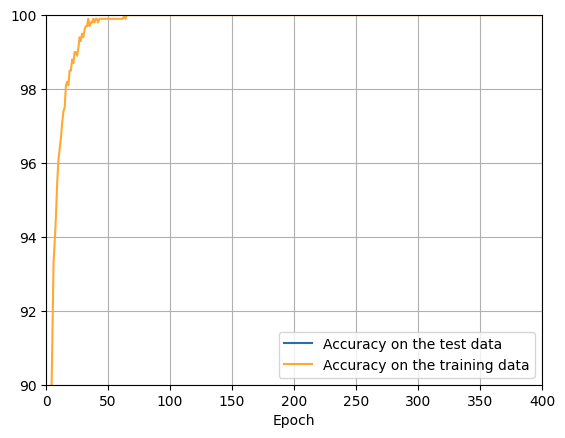

CPU times: user 14min 42s, sys: 11min 45s, total: 26min 28s
Wall time: 16min 41s


In [ ]:
%%time
if __name__ == "__main__":
    filename = input("Enter a file name: ")
    num_epochs = int(input("Enter the number of epochs to run for: "))
    training_cost_xmin = int(input("training_cost_xmin (suggest 200): "))
    test_accuracy_xmin = int(input("test_accuracy_xmin (suggest 200): "))
    test_cost_xmin = int(input("test_cost_xmin (suggest 0): "))
    training_accuracy_xmin = int(input("training_accuracy_xmin (suggest 0): "))
    training_set_size = int(input("Training set size (suggest 1000): "))
    lmbda = float(input("Enter the regularization parameter, lambda (suggest: 5.0): "))
    main(filename, num_epochs, training_cost_xmin,
         test_accuracy_xmin, test_cost_xmin, training_accuracy_xmin,
         training_set_size, lmbda)

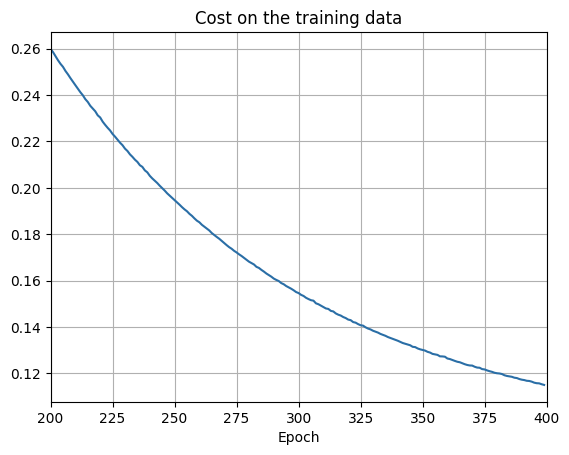

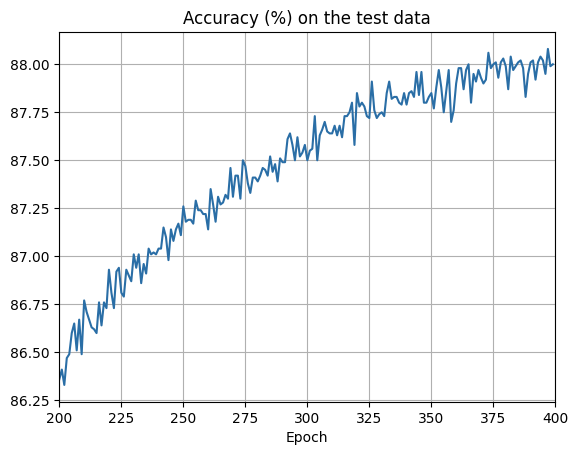

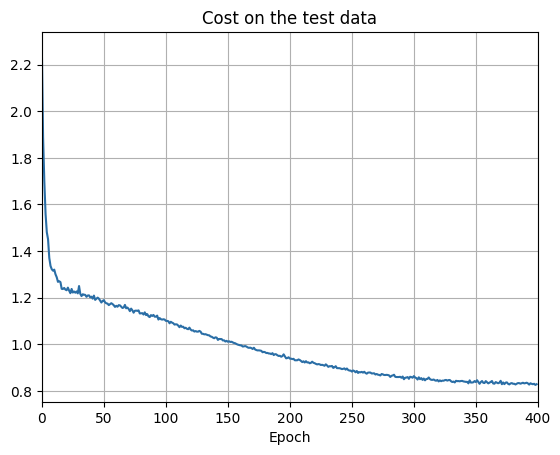

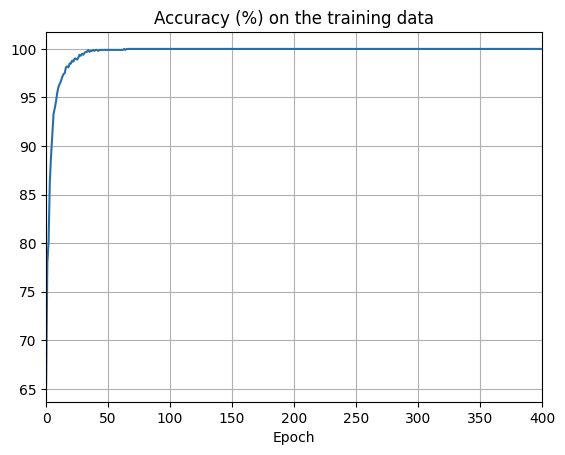

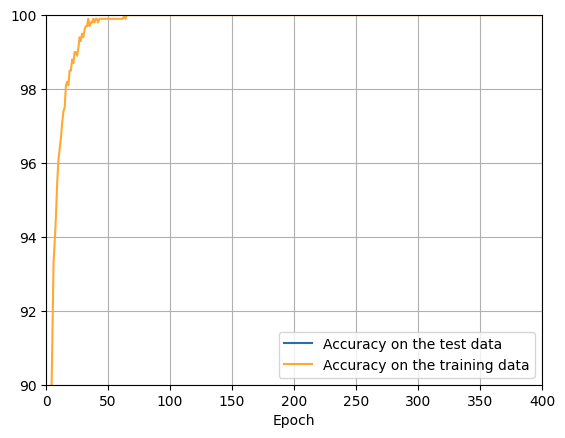

In [ ]:
training_cost_xmin=200
test_accuracy_xmin=200
test_cost_xmin=0
training_accuracy_xmin=0
training_set_size=1000
lmbda=0.1

make_plots('/content/train1000-lambda_point1', 400,
               training_cost_xmin,
               test_accuracy_xmin,
               test_cost_xmin,
               training_accuracy_xmin,
               training_set_size)

----
The cost on the training data decreases over the whole time, much as it did in the earlier, unregularized case

 - training accuracy: **100%**
 - test accuracy: **88.08%**
 - training acc $-$ test acc: **11.92%**

Clearly, the use of regularization has suppressed overfitting. What's
more, the accuracy is considerably higher, with a peak classification
accuracy of $\textbf{88.08 %}$ for the regularized case ($\lambda = 0.1$), compared to the peak of $\textbf{83.05 %}$ obtained in the unregularized case. Indeed, we could almost certainly get considerably better results by continuing to train past 400 epochs. It seems that, empirically, regularization is causing our network to generalize better, and considerably reducing the effects of overfitting.

What happens if we move out of the artificial environment of just having
1,000 training images, and return to the full 50,000 image training set?
Of course, we've seen already that overfitting is much less of a problem
with the full 50,000 images. Does regularization help any further? Let's
keep the hyper-parameters the same as before - $30$ epochs, learning
rate $0.5$, mini-batch size of $10$. However, we need to **modify the
regularization parameter.** The reason is because the size $n$ of the
training set has changed from $n = 1,000$ to $n = 50,000$, and this
changes the weight decay factor $1 - \frac{\eta \lambda}{n}$. If we
continued to use $\lambda = 0.1$ that would mean much less weight decay,
and thus much less of a regularization effect. We compensate by changing
to $\lambda = 5.0$.
$$$$
$$\frac{\lambda}{n}=\frac{0.1}{1000} = \frac{\lambda_{50000}}{50000}$$
$$$$
$${\lambda_{50000}} = \frac{0.1 \times 50000}{1000} = 5$$
$$$$
Okay, let's train our network, stopping first to re-initialize the
weights:

-----

Enter a file name: train50000-lambda5
Enter the number of epochs to run for: 30
training_cost_xmin (suggest 200): 15
test_accuracy_xmin (suggest 200): 15
test_cost_xmin (suggest 0): 0
training_accuracy_xmin (suggest 0): 0
Training set size (suggest 1000): 50000
Enter the regularization parameter, lambda (suggest: 5.0): 5
Epoch 0 training complete
Cost on training data: 1.2734727241718988
Accuracy on training data: 46164 / 50000
Cost on evaluation data: 4.2905433057644355
Accuracy on evaluation data: 9216 / 10000
Epoch 1 training complete
Cost on training data: 0.9419156008205658
Accuracy on training data: 46721 / 50000
Cost on evaluation data: 2.9450097579589958
Accuracy on evaluation data: 9279 / 10000
Epoch 2 training complete
Cost on training data: 0.7565864531292588
Accuracy on training data: 46957 / 50000
Cost on evaluation data: 2.155298294411187
Accuracy on evaluation data: 9336 / 10000
Epoch 3 training complete
Cost on training data: 0.6028287666804373
Accuracy on training data

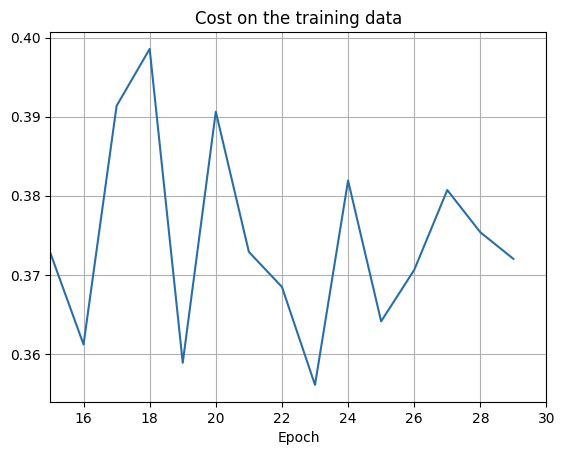

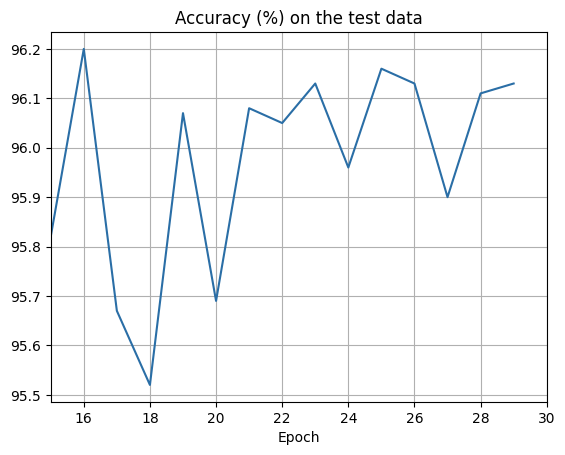

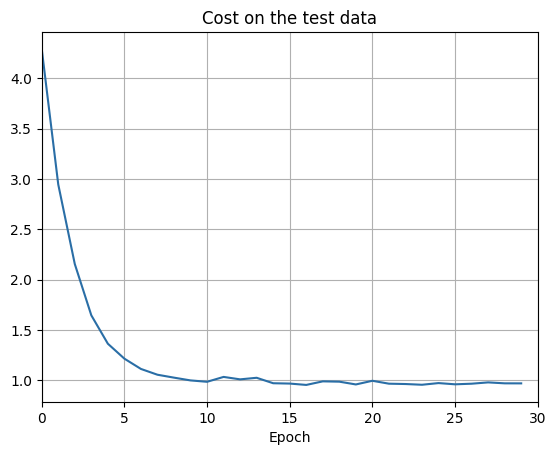

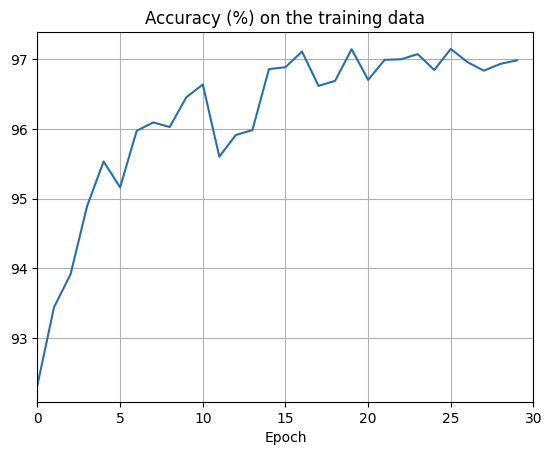

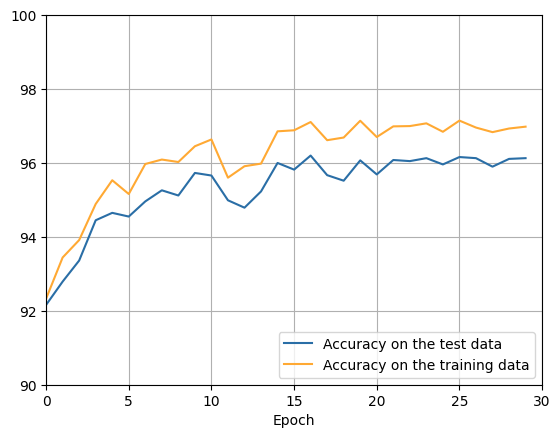

CPU times: user 5min 52s, sys: 3min 59s, total: 9min 51s
Wall time: 6min 41s


In [ ]:
%%time
if __name__ == "__main__":
    filename = input("Enter a file name: ")
    num_epochs = int(input("Enter the number of epochs to run for: "))
    training_cost_xmin = int(input("training_cost_xmin (suggest 200): "))
    test_accuracy_xmin = int(input("test_accuracy_xmin (suggest 200): "))
    test_cost_xmin = int(input("test_cost_xmin (suggest 0): "))
    training_accuracy_xmin = int(input("training_accuracy_xmin (suggest 0): "))
    training_set_size = int(input("Training set size (suggest 1000): "))
    lmbda = float(input("Enter the regularization parameter, lambda (suggest: 5.0): "))
    main(filename, num_epochs, training_cost_xmin,
         test_accuracy_xmin, test_cost_xmin, training_accuracy_xmin,
         training_set_size, lmbda)

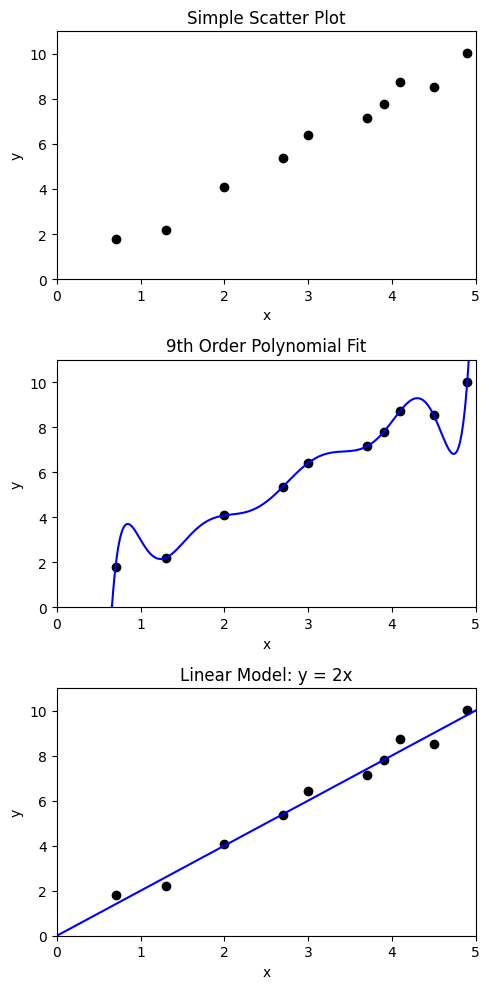

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Data points
x = np.array([0.7, 1.3, 2, 2.7, 3, 3.7, 3.9, 4.1, 4.5, 4.9])
# y = np.array([1.8, 2.2, 4, 5, 6, 7, 7.5, 8, 9.2, 10])
y = np.array([p(i) for i in x])

# Polynomial function
def p(x):
    return (2.20539187e-01 * x**9
            - 5.49142821 * x**8
            + 5.87844045e+01 * x**7
            - 3.53892824e+02 * x**6
            + 1.31549254e+03 * x**5
            - 3.11809836e+03 * x**4
            + 4.69080366e+03 * x**3
            - 4.29612493e+03 * x**2
            + 2.16228823e+03 * x
            - 4.50983951e+02)

# Function to create a plot
def create_plot(ax, x, y, fit_func=None, title=''):
    ax.scatter(x, y, color='black')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

    if fit_func:
        x_fit = np.linspace(0, 5, 1000)
        y_fit = fit_func(x_fit)
        ax.plot(x_fit, y_fit, color='blue')

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10))

# Plot 1: Simple scatter plot
create_plot(ax1, x, y, title='Simple Scatter Plot')

# Plot 2: 9th order polynomial fit
poly = Polynomial.fit(x, y, 9)
create_plot(ax2, x, y, fit_func=p, title='9th Order Polynomial Fit')

# Plot 3: Linear model y = 2x
linear_model = lambda x: 2 * x
create_plot(ax3, x, y, fit_func=linear_model, title='Linear Model: y = 2x')

plt.tight_layout()
plt.show()

----
## Why does regularization help reduce overfitting?

We've seen empirically that regularization helps reduce overfitting.
That's encouraging but, unfortunately, it's not obvious why
regularization helps! A standard story people tell to explain what's
going on is along the following lines: smaller weights are, in some
sense, lower complexity, and so provide a simpler and more powerful
explanation for the data, and should thus be preferred. That's a pretty
terse story, though, and contains several elements that perhaps seem
dubious or mystifying. Let's unpack the story and examine it critically.
To do that, let's suppose we have a simple data set for which we wish to
build a model:

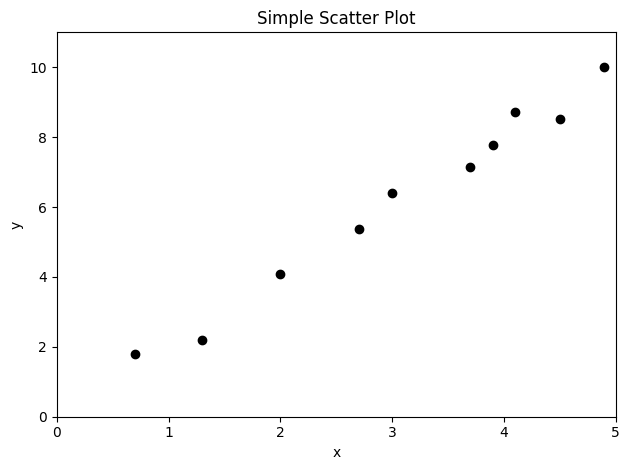

In [ ]:
# @title
fig, ax = plt.subplots()
create_plot(ax, x, y, title='Simple Scatter Plot')
plt.tight_layout()
plt.show()

---

Implicitly, we're studying some real-world phenomenon here, with $x$ and
$y$ representing real-world data. Our goal is to build a model which
lets us predict $y$ as a function of $x$. We could try using neural
networks to build such a model, but I'm going to do something even
simpler: I'll try to model $y$ as a polynomial in $x$. I'm doing this
instead of using neural nets because using polynomials will make things
particularly transparent. Once we've understood the polynomial case,
we'll translate to neural networks. Now, there are ten points in the
graph above, which means we can find a unique $9$th-order polynomial $y
= a_0 x^9 + a_1 x^8 + \ldots + a_9$ which fits the data exactly. Here's
the graph of that polynomial:

----

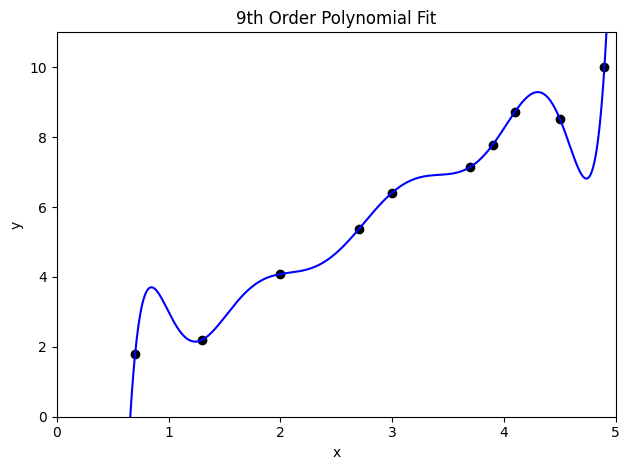

In [ ]:
# @title
fig, ax = plt.subplots()
create_plot(ax, x, y, fit_func=p, title='9th Order Polynomial Fit')
plt.tight_layout()
plt.show()

----
That provides an exact fit. But we can also get a good fit using the
linear model $y = 2x$:

----

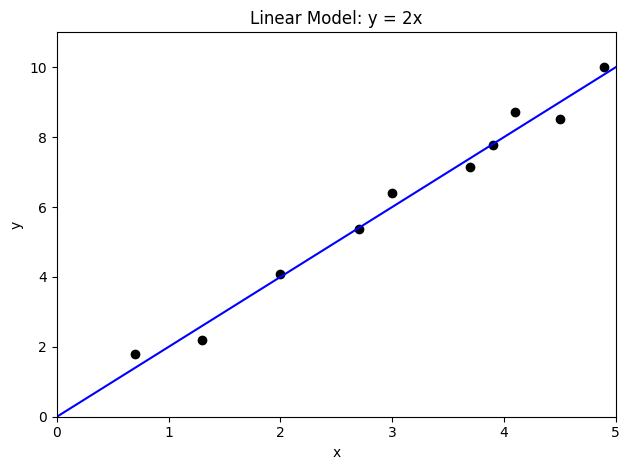

In [ ]:
# @title
fig, ax = plt.subplots()
create_plot(ax, x, y, fit_func=linear_model, title='Linear Model: y = 2x')
plt.tight_layout()
plt.show()

----
Which of these is the better model? Which is more likely to be true? And
which model is more likely to generalize well to other examples of the
same underlying real-world phenomenon?

These are difficult questions. In fact, we can't determine with
certainty the answer to any of the above questions, without much more
information about the underlying real-world phenomenon. But let's
consider two possibilities:
1. The $9$th order polynomial is, in fact, the model which truly describes the real-world phenomenon, and the model will therefore generalize perfectly;
2. The correct model is $y = 2x$, but there's a little additional noise due to, say, measurement error, and that's why the model isn't an exact fit.

It's not *a priori* possible to say which of these two possibilities is
correct. (Or, indeed, if some third possibility holds). Logically,
either could be true. And it's not a trivial difference. It's true that
on the data provided there's only a small difference between the two
models. But suppose we want to predict the value of $y$ corresponding to
some large value of $x$, much larger than any shown on the graph above.
If we try to do that there will be a dramatic difference between the
predictions of the two models, as the $9$th order polynomial model comes
to be dominated by the $x^9$ term, while the linear model remains, well,
linear.

One point of view is to say that in science we should go with the
simpler explanation, unless compelled not to. When we find a simple
model that seems to explain many data points we are tempted to shout
"Eureka!" After all, it seems unlikely that a simple explanation should
occur merely by coincidence. Rather, we suspect that the model must be
expressing some underlying truth about the phenomenon. In the case at
hand, the model $y = 2x+{\rm noise}$ seems much simpler than $y = a_0
x^9 + a_1 x^8 + \ldots$. It would be surprising if that simplicity had
occurred by chance, and so we suspect that $y = 2x+{\rm noise}$
expresses some underlying truth. In this point of view, the 9th order
model is really just learning the effects of local noise. And so while
the 9th order model works perfectly for these particular data points,
the model will fail to generalize to other data points, and the noisy
linear model will have greater predictive power.

Let's see what this point of view means for neural networks. Suppose our
network mostly has small weights, as will tend to happen in a
regularized network. The smallness of the weights means that the
behaviour of the network won't change too much if we change a few random
inputs here and there. That makes it difficult for a regularized network
to learn the effects of local noise in the data. Think of it as a way of
making it so single pieces of evidence don't matter too much to the
output of the network. Instead, a regularized network learns to respond
to types of evidence which are seen often across the training set. By
contrast, a network with large weights may change its behaviour quite a
bit in response to small changes in the input. And so an unregularized
network can use large weights to learn a complex model that carries a
lot of information about the noise in the training data. <u>In a nutshell,
regularized networks are constrained to build relatively simple models
based on patterns seen often in the training data, and are resistant to
learning peculiarities of the noise in the training data.</u> The hope is
that this will force our networks to do real learning about the
phenomenon at hand, and to generalize better from what they learn.

With that said, this idea of preferring simpler explanation should make
you nervous. People sometimes refer to this idea as **"Occam's Razor",** and
will zealously apply it as though it has the status of some general
scientific principle. But, of course, it's not a general scientific
principle. There is no *a priori* logical reason to prefer simple
explanations over more complex explanations. Indeed, sometimes the more
complex explanation turns out to be correct.

Let me describe two examples where more complex explanations have turned
out to be correct. In the 1940s the physicist Marcel Schein announced
the discovery of a new particle of nature. The company he worked for,
General Electric, was ecstatic, and publicized the discovery widely. But
the physicist Hans Bethe was skeptical. Bethe visited Schein, and looked
at the plates showing the tracks of Schein's new particle. Schein showed
Bethe plate after plate, but on each plate Bethe identified some problem
that suggested the data should be discarded. Finally, Schein showed
Bethe a plate that looked good. Bethe said it might just be a
statistical fluke. Schein: "Yes, but the chance that this would be
statistics, even according to your own formula, is one in five." Bethe:
"But we have already looked at five plates." Finally, Schein said: "But
on my plates, each one of the good plates, each one of the good
pictures, you explain by a different theory, whereas I have one
hypothesis that explains all the plates, that they are \[the new
particle\]." Bethe replied: "The sole difference between your and my
explanations is that yours is wrong and all of mine are right. Your
single explanation is wrong, and all of my multiple explanations are
right." Subsequent work confirmed that Nature agreed with Bethe, and
Schein's particle is no more**[3]**.

As a second example, in 1859 the astronomer Urbain Le Verrier observed
that the orbit of the planet Mercury doesn't have quite the shape that
Newton's theory of gravitation says it should have. It was a tiny, tiny
deviation from Newton's theory, and several of the explanations
proferred at the time boiled down to saying that Newton's theory was
more or less right, but needed a tiny alteration. In 1916, Einstein
showed that the deviation could be explained very well using his general
theory of relativity, a theory radically different to Newtonian
gravitation, and based on much more complex mathematics. Despite that
additional complexity, today it's accepted that Einstein's explanation
is correct, and Newtonian gravity, even in its modified forms, is wrong.
This is in part because we now know that Einstein's theory explains many
other phenomena which Newton's theory has difficulty with. Furthermore,
and even more impressively, Einstein's theory accurately predicts
several phenomena which aren't predicted by Newtonian gravity at all.
But these impressive qualities weren't entirely obvious in the early
days. If one had judged merely on the grounds of simplicity, then some
modified form of Newton's theory would arguably have been more
attractive.

There are three morals to draw from these stories.
- $\text{1st}$, it can be quite a subtle business deciding which of two explanations is truly "simpler".
- $\text{2nd}$, even if we can make such a judgment, simplicity is a guide that must be used with great caution!
- $\text{3rd}$, the true test of a model is not simplicity, but rather how well it does in predicting new phenomena, in new regimes of behaviour.

With that said, and keeping the need for caution in mind, **it's an
empirical fact that regularized neural networks usually generalize
better than unregularized networks.** And so through the remainder of the
book we will make frequent use of regularization. I've included the
stories above merely to help convey why no-one has yet developed an
entirely convincing theoretical explanation for why regularization helps
networks generalize. Indeed, researchers continue to write papers where
they try different approaches to regularization, compare them to see
which works better, and attempt to understand why different approaches
work better or worse. And so you can view regularization as something of
a kludge. While it often helps, we don't have an entirely satisfactory
systematic understanding of what's going on, merely incomplete
heuristics and rules of thumb.

There's a deeper set of issues here, issues which go to the heart of
science. It's the question of how we generalize. Regularization may give
us a computational magic wand that helps our networks generalize better,
but it doesn't give us a principled understanding of how generalization
works, nor of what the best approach is**[4]**.

This is particularly galling because in everyday life, we humans
generalize phenomenally well. Shown just a few images of an elephant a
child will quickly learn to recognize other elephants. Of course, they
may occasionally make mistakes, perhaps confusing a rhinoceros for an
elephant, but in general this process works remarkably accurately. So we
have a system - the human brain - with a huge number of free parameters.
And after being shown just one or a few training images that system
learns to generalize to other images. Our brains are, in some sense,
regularizing amazingly well! How do we do it? At this point we don't
know. I expect that in years to come we will develop more powerful
techniques for regularization in artificial neural networks, techniques
that will ultimately enable neural nets to generalize well even from
small data sets.

In fact, our networks already generalize better than one might *a
priori* expect. A network with 100 hidden neurons has nearly 80,000
parameters. We have only 50,000 images in our training data. It's like
trying to fit an 80,000th degree polynomial to 50,000 data points. By
all rights, our network should overfit terribly. And yet, as we saw
earlier, such a network actually does a pretty good job generalizing.
Why is that the case? It's not well understood. It has been
conjectured**[5]** that _"the dynamics of gradient descent learning in
multilayer nets has a 'self-regularization' effect"._ This is
exceptionally fortunate, but it's also somewhat disquieting that we
don't understand why it's the case. In the meantime, we will adopt the
pragmatic approach and use regularization whenever we can. Our neural
networks will be the better for it.

Let me conclude this section by returning to a detail which I left
unexplained earlier: the fact that L2 regularization *doesn't* constrain
the biases. Of course, it would be easy to modify the regularization
procedure to regularize the biases. Empirically, doing this often
doesn't change the results very much, so to some extent it's merely a
convention whether to regularize the biases or not. However, it's worth
noting that having a large bias doesn't make a neuron sensitive to its
inputs in the same way as having large weights. And so we don't need to
worry about large biases enabling our network to learn the noise in our
training data. At the same time, allowing large biases gives our
networks more flexibility in behaviour - in particular, large biases
make it easier for neurons to saturate, which is sometimes desirable.
For these reasons we don't usually include bias terms when regularizing.
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
3. _The story is related by the physicist Richard Feynman in an
[interview](https://www.aip.org/history-programs/niels-bohr-library/oral-histories/5020-4) with the historian Charles Weiner._<br>
4. _These issues go back to the [problem of induction](http://en.wikipedia.org/wiki/Problem_of_induction), famously discussed by the Scottish philosopher David Hume in ["An Enquiry Concerning Human Understanding"](http://www.gutenberg.org/ebooks/9662) (1748). The problem of induction has been given a modern machine learning form in the no-free lunch theorem ([link](https://www.cs.ubc.ca/~hutter/earg/papers07/00585893.pdf))
of David Wolpert and William Macready (1997)._<br>
5. _In [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner (1998)._

----
# Other Regularization Techniques: L1 Reg., Dropout, Artificial Expansion of Training Data



---

There are many regularization techniques other than L2 regularization. In fact, so many techniques have been developed that I can't possibly summarize them all. In this section I briefly describe three other approaches to reducing overfitting:
- L1 regularization,
- dropout, &
- artificially increasing the training set size.

We won't go into nearly as much depth studying these techniques as we did earlier. Instead, the purpose is to get familiar with the main ideas, and to appreciate something of the diversity of regularization techniques available.

---
**L1 regularization:** In this approach we modify the unregularized cost
function by adding the sum of the absolute values of the weights:

<span id="eqtn11" class="displaced_anchor"></span>
\begin{eqnarray}
C = C_0 + \frac{\lambda}{n} \sum_w \|w\|.
\tag{11}
\end{eqnarray}

Intuitively, this is similar to L2 regularization, penalizing large
weights, and tending to make the network prefer small weights. Of
course, the L1 regularization term isn't the same as the L2
regularization term, and so we shouldn't expect to get exactly the same
behaviour. Let's try to understand how the behaviour of a network
trained using L1 regularization differs from a network trained using L2
regularization.

To do that, we'll look at the partial derivatives of the cost function.
Differentiating **Equation (11)** we obtain:

<span id="eqtn12" class="displaced_anchor"></span>
\begin{eqnarray}
\frac{\partial C}{\partial w} = \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} {\rm sgn}(w),
\tag{12}
\end{eqnarray}

where ${\rm sgn}(w)$ is the sign of $w$, that is, $+1$ if $w$ is
positive, and $-1$ if $w$ is negative. Using this expression, we can
easily modify backpropagation to do stochastic gradient descent using L1
regularization. The resulting update rule for an L1 regularized network
is

<span id="eqtn13" class="displaced_anchor"></span>
\begin{eqnarray}
w \rightarrow w' = w-\frac{\eta \lambda}{n} \mbox{sgn}(w) - \eta
\frac{\partial C_0}{\partial w},
\tag{13}
\end{eqnarray}

where, as per usual, we can estimate $\partial C_0 / \partial w$ using a
mini-batch average, if we wish. Compare that to the update rule for L2
regularization (c.f. **Equation (9)**),

<span id="eqtn14" class="displaced_anchor"></span>
\begin{eqnarray}
w \rightarrow w' = w\left(1 - \frac{\eta \lambda}{n} \right) - \eta
\frac{\partial C_0}{\partial w}.
\tag{14}
\end{eqnarray}

In both expressions the effect of regularization is to shrink the weights. This
accords with our intuition that both kinds of regularization penalize
large weights. But the way the weights shrink is different. In L1
regularization, the weights shrink by a constant amount toward $0$. In
L2 regularization, the weights shrink by an amount which is proportional
to $w$. And so when a particular weight has a large magnitude, $\|w\|$,
L1 regularization shrinks the weight much less than L2 regularization
does. By contrast, when $\|w\|$ is small, L1 regularization shrinks the
weight much more than L2 regularization. <u>The net result is that L1
regularization tends to concentrate the weight of the network in a
relatively small number of high-importance connections, while the other
weights are driven toward zero.</u>

I've glossed over an issue in the above discussion, which is that the
partial derivative $\partial C / \partial w$ isn't defined when $w = 0$.
The reason is that the function $\|w\|$ has a sharp "corner" at $w = 0$,
and so isn't differentiable at that point. That's okay, though. What
we'll do is just apply the usual (unregularized) rule for stochastic
gradient descent when $w = 0$. That should be okay - intuitively, the
effect of regularization is to shrink weights, and obviously it can't
shrink a weight which is already $0$. To put it more precisely, we'll
use **Equations (12) and (13)** with the convention that $\mbox{sgn}(0) = 0$. That gives a nice, compact rule for doing stochastic gradient descent with L1 regularization.

---
**Dropout:** Dropout is a radically different technique for
regularization. Unlike L1 and L2 regularization, dropout doesn't rely on
modifying the cost function. Instead, in dropout we modify the network
itself. Let me describe the basic mechanics of how dropout works, before
getting into why it works, and what the results are.

Suppose we're trying to train a network **(Fig. a)**. In particular, suppose we have a training input $x$ and corresponding desired output $y$. Ordinarily, we'd train by forward-propagating $x$ through the network, and then backpropagating to determine the contribution to the gradient. With dropout, this process is modified. We start by randomly (and temporarily) deleting half the hidden neurons in the network, while leaving the input and output neurons untouched. After doing this, we'll end up with a network along the following lines. Note that the dropout neurons, i.e., the neurons which have been temporarily deleted, are still ghosted in as seen in **(Fig. b)**.

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.19.24_PM.png)

We forward-propagate the input $x$ through the modified network, and
then backpropagate the result, also through the modified network. After
doing this over a mini-batch of examples, we update the appropriate
weights and biases. We then repeat the process, first restoring the
dropout neurons, then choosing a new random subset of hidden neurons to
delete, estimating the gradient for a different mini-batch, and updating
the weights and biases in the network.

By repeating this process over and over, our network will learn a set of
weights and biases. Of course, those weights and biases will have been
learnt under conditions in which half the hidden neurons were dropped
out. When we actually run the full network that means that twice as many
hidden neurons will be active. To compensate for that, we halve the
weights outgoing from the hidden neurons.

This dropout procedure may seem strange and *ad hoc*. Why would we
expect it to help with regularization? To explain what's going on, I'd
like you to briefly stop thinking about dropout, and instead imagine
training neural networks in the standard way (no dropout). In
particular, imagine we train several different neural networks, all
using the same training data. Of course, the networks may not start out
identical, and as a result after training they may sometimes give
different results. When that happens we could use some kind of averaging
or voting scheme to decide which output to accept. For instance, if we
have trained five networks, and three of them are classifying a digit as
a "3", then it probably really is a "3". The other two networks are
probably just making a mistake. This kind of averaging scheme is often
found to be a powerful (though expensive) way of reducing overfitting.
The reason is that the different networks may overfit in different ways,
and averaging may help eliminate that kind of overfitting.

What's this got to do with dropout? Heuristically, when we dropout
different sets of neurons, it's rather like we're training different
neural networks. And so the dropout procedure is like averaging the
effects of a very large number of different networks. The different
networks will overfit in different ways, and so, hopefully, the net
effect of dropout will be to reduce overfitting.

A related heuristic explanation for dropout is given in one of the
earliest papers to use the technique**[6]**:
>"This technique reduces complex co-adaptations of neurons, since a
neuron cannot rely on the presence of particular other neurons. It is,
therefore, forced to learn more robust features that are useful in
conjunction with many different random subsets of the other neurons."

In other words, if we think of our network as a model which is making
predictions, then we can think of dropout as a way of making sure that
the model is robust to the loss of any individual piece of evidence. In
this, it's somewhat similar to L1 and L2 regularization, which tend to
reduce weights, and thus make the network more robust to losing any
individual connection in the network.

Of course, the true measure of dropout is that it has been very
successful in improving the performance of neural networks. The original
paper**[7]** introducing the technique applied it to many different tasks. For us, it's of particular interest that they applied dropout to MNIST digit
classification, using a vanilla feedforward neural network along lines
similar to those we've been considering. The paper noted that the best
result anyone had achieved up to that point using such an architecture
was $98.4$ percent classification accuracy on the test set. They
improved that to $98.7$ percent accuracy using a combination of dropout
and a modified form of L2 regularization. Similarly impressive results
have been obtained for many other tasks, including problems in image and
speech recognition, and natural language processing. Dropout has been
especially useful in training large, deep networks, where the problem of
overfitting is often acute.

---
**Artificially expanding the training data:** We saw earlier that our
MNIST classification accuracy dropped down to percentages in the mid-80s
when we used only 1,000 training images. It's not surprising that this
is the case, since less training data means our network will be exposed
to fewer variations in the way human beings write digits. Let's try
training our 30 hidden neuron network with a variety of different
training data set sizes, to see how performance varies. We train using a
mini-batch size of 10, a learning rate $\eta = 0.5$, a regularization
parameter $\lambda = 5.0$, and the cross-entropy cost function. We will
train for 30 epochs when the full training data set is used, and scale
up the number of epochs proportionally when smaller training sets are
used. To ensure the weight decay factor remains the same across training
sets, we will use a regularization parameter of $\lambda = 5.0$ when the
full training data set is used, and scale down $\lambda$ proportionally
when smaller training sets are used.
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
6. _[ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton (2012)._<br>
7. _[Improving neural networks by preventing co-adaptation of feature detectors](http://arxiv.org/pdf/1207.0580.pdf) by Geoffrey Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov (2012). Note that the paper discusses a number of subtleties that I have glossed over in this brief introduction._

Streaming output truncated to the last 5000 lines.
Epoch 866 training complete
Epoch 867 training complete
Epoch 868 training complete
Epoch 869 training complete
Epoch 870 training complete
Epoch 871 training complete
Epoch 872 training complete
Epoch 873 training complete
Epoch 874 training complete
Epoch 875 training complete
Epoch 876 training complete
Epoch 877 training complete
Epoch 878 training complete
Epoch 879 training complete
Epoch 880 training complete
Epoch 881 training complete
Epoch 882 training complete
Epoch 883 training complete
Epoch 884 training complete
Epoch 885 training complete
Epoch 886 training complete
Epoch 887 training complete
Epoch 888 training complete
Epoch 889 training complete
Epoch 890 training complete
Epoch 891 training complete
Epoch 892 training complete
Epoch 893 training complete
Epoch 894 training complete
Epoch 895 training complete
Epoch 896 training complete
Epoch 897 training complete
Epoch 898 training complete
Epoch 899 training comple

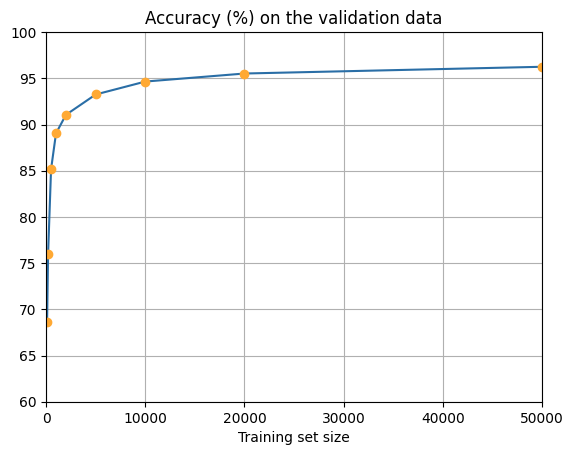

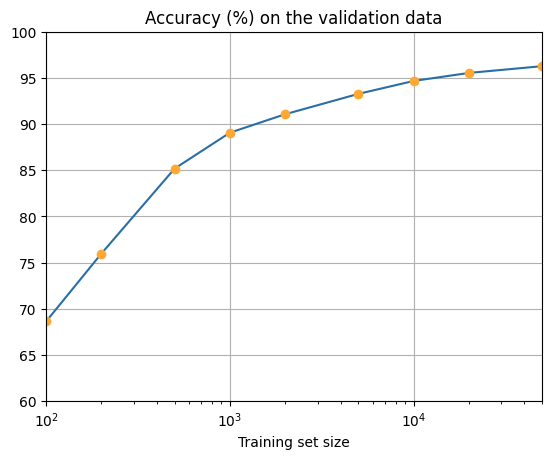

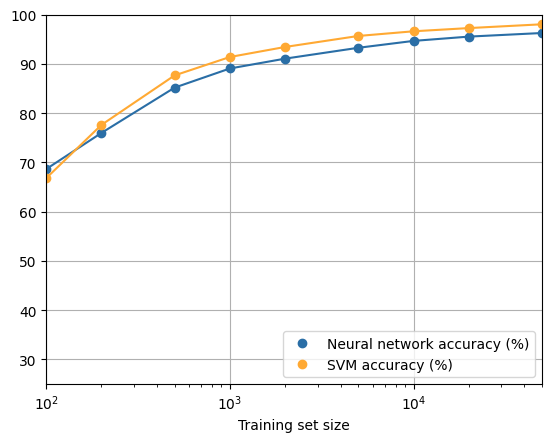

In [ ]:
# @title
"""more_data
~~~~~~~~~~~~

Plot graphs to illustrate the performance of MNIST when different size
training sets are used.

"""

# Standard library
import json
import random
import sys

# My library
sys.path.append('../src/')
import mnist_loader
# import network2

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

# The sizes to use for the different training sets
SIZES = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

def main():
    run_networks()
    run_svms()
    make_plots()

def run_networks():
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

    # Convert data to lists
    training_data = list(training_data)
    validation_data = list(validation_data)
    test_data = list(test_data)

    net = Network2mat([784, 30, 10], cost=CrossEntropyCost())
    accuracies = []
    for size in SIZES:
        print("\n\nTraining network with data set size %s" % size)
        net.large_weight_initializer()
        num_epochs = int(1500000 / size)
        net.SGD(training_data[:size], num_epochs, 10, 0.5, lmbda = size*0.0001)
        accuracy = net.accuracy(validation_data) / 100.0
        print("Accuracy was %s percent" % accuracy)
        accuracies.append(accuracy)
    f = open("more_data.json", "w")
    json.dump(accuracies, f)
    f.close()

def run_svms():
    svm_training_data, svm_validation_data, svm_test_data \
        = mnist_loader.load_data()
    accuracies = []
    for size in SIZES:
        print("\n\nTraining SVM with data set size %s" % size)
        clf = svm.SVC()
        clf.fit(svm_training_data[0][:size], svm_training_data[1][:size])
        predictions = [int(a) for a in clf.predict(svm_validation_data[0])]
        accuracy = sum(int(a == y) for a, y in
                       zip(predictions, svm_validation_data[1])) / 100.0
        print("Accuracy was %s percent" % accuracy)
        accuracies.append(accuracy)
    f = open("more_data_svm.json", "w")
    json.dump(accuracies, f)
    f.close()

def make_plots():
    f = open("more_data.json", "r")
    accuracies = json.load(f)
    f.close()
    f = open("more_data_svm.json", "r")
    svm_accuracies = json.load(f)
    f.close()
    make_linear_plot(accuracies)
    make_log_plot(accuracies)
    make_combined_plot(accuracies, svm_accuracies)

def make_linear_plot(accuracies):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(SIZES, accuracies, color='#2A6EA6')
    ax.plot(SIZES, accuracies, "o", color='#FFA933')
    ax.set_xlim(0, 50000)
    ax.set_ylim(60, 100)
    ax.grid(True)
    ax.set_xlabel('Training set size')
    ax.set_title('Accuracy (%) on the validation data')
    plt.show()

def make_log_plot(accuracies):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(SIZES, accuracies, color='#2A6EA6')
    ax.plot(SIZES, accuracies, "o", color='#FFA933')
    ax.set_xlim(100, 50000)
    ax.set_ylim(60, 100)
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Training set size')
    ax.set_title('Accuracy (%) on the validation data')
    plt.show()

def make_combined_plot(accuracies, svm_accuracies):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(SIZES, accuracies, color='#2A6EA6')
    ax.plot(SIZES, accuracies, "o", color='#2A6EA6',
            label='Neural network accuracy (%)')
    ax.plot(SIZES, svm_accuracies, color='#FFA933')
    ax.plot(SIZES, svm_accuracies, "o", color='#FFA933',
            label='SVM accuracy (%)')
    ax.set_xlim(100, 50000)
    ax.set_ylim(25, 100)
    ax.set_xscale('log')
    ax.grid(True)
    ax.set_xlabel('Training set size')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main()

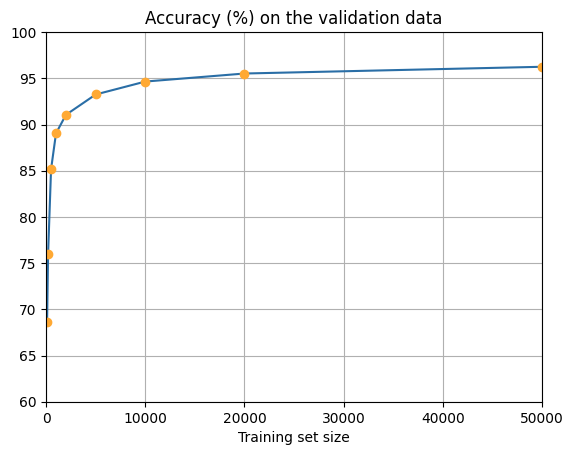

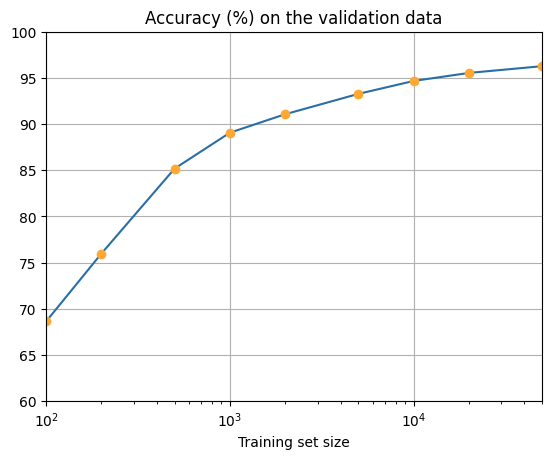

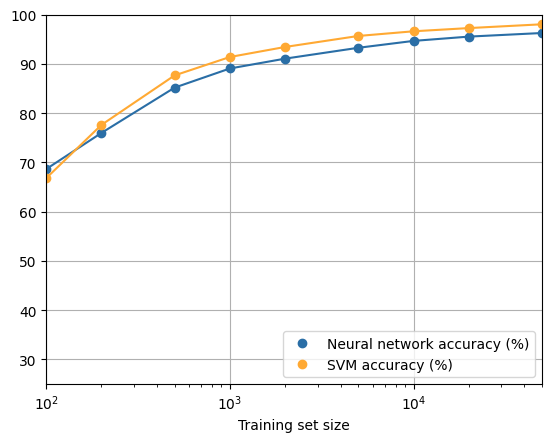

In [ ]:
make_plots()

---
As you can see, the classification accuracies improve considerably as we use more training data. Presumably this improvement would continue still further if more data was available. Of course, looking at the graph above it does appear that we're getting near saturation. Suppose, however, that we redo the graph with the training set size plotted logarithmically. It seems clear that the logarithmic graph is still going up toward the end. This suggests that if we used vastly more training data - say, millions or even billions of handwriting samples, instead of just 50,000 - then we'd likely get considerably better performance, even from this very small network.

Obtaining more training data is a great idea. Unfortunately, it can be
expensive, and so is not always possible in practice. However, there's
another idea which can work nearly as well, and that's to artificially
expand the training data. Suppose, for example, that we take an MNIST
training image of a five, and rotate it by a small amount, let's say 15 degrees: It's still recognizably the same digit. And yet at the pixel level it's
quite different to any image currently in the MNIST training data. It's
conceivable that adding this image to the training data might help our
network learn more about how to classify digits. What's more, obviously
we're not limited to adding just this one image. We can expand our
training data by making *many* small rotations of *all* the MNIST
training images, and then using the expanded training data to improve
our network's performance.

This idea is very powerful and has been widely used. Let's look at some
of the results from a paper**[8]** which applied several variations of the idea to MNIST. One of the neural network architectures they considered was along similar lines to what we've been using, a feedforward network with $800$ hidden neurons and using the cross-entropy cost function. Running the network with the standard MNIST training data they achieved a classification accuracy of $98.4$ percent on their test set. But then they expanded the training data, using not just rotations, as I described above, but also translating and skewing the
images. By training on the expanded data set they increased their
network's accuracy to $98.9$ percent. They also experimented with what
they called "elastic distortions", a special type of image distortion
intended to emulate the random oscillations found in hand muscles. By
using the elastic distortions to expand the data they achieved an even
higher accuracy, $99.3$ percent. Effectively, they were broadening the
experience of their network by exposing it to the sort of variations
that are found in real handwriting.

Variations on this idea can be used to improve performance on many
learning tasks, not just handwriting recognition. The general principle
is to expand the training data by applying operations that reflect
real-world variation. It's not difficult to think of ways of doing this.
Suppose, for example, that you're building a neural network to do speech
recognition. We humans can recognize speech even in the presence of
distortions such as background noise. And so you can expand your data by
adding background noise. We can also recognize speech if it's sped up or
slowed down. So that's another way we can expand the training data.
These techniques are not always used - for instance, instead of
expanding the training data by adding noise, it may well be more
efficient to clean up the input to the network by first applying a noise
reduction filter. Still, it's worth keeping the idea of expanding the
training data in mind, and looking for opportunities to apply it.

---
**An aside on big data and what it means to compare classification accuracies:** Let's look again at how our neural network's accuracy
varies with training set size in the logarithmic graph above. Suppose that instead of using a neural network we use some other machine
learning technique to classify digits. For instance, let's try using the
support vector machines (SVM). Don't worry if you're
not familiar with SVMs, we don't need to understand their details right now.
Instead, we'll use the SVM supplied by the [scikit-learn
library](http://scikit-learn.org/stable/). Here's how SVM performance
varies as a function of training set size. I've plotted the neural net
results as well, to make comparison easy in the final graph above.

Probably the first thing that strikes you about this graph is that our
neural network outperforms the SVM for every training set size. That's
nice, although you shouldn't read too much into it, since I just used
the out-of-the-box settings from scikit-learn's SVM, while we've done a
fair bit of work improving our neural network. A more subtle but more
interesting fact about the graph is that if we train our SVM using
50,000 images then it actually has better performance (94.48 percent
accuracy) than our neural network does when trained using 5,000 images
(93.24 percent accuracy). In other words, more training data can
sometimes compensate for differences in the machine learning algorithm
used.

Something even more interesting can occur. Suppose we're trying to solve
a problem using two machine learning algorithms, algorithm A and
algorithm B. It sometimes happens that algorithm A will outperform
algorithm B with one set of training data, while algorithm B will
outperform algorithm A with a different set of training data. We don't
see that above - it would require the two graphs to cross - but it does
happen**[9]**. The correct response to the question "Is algorithm A better than algorithm B?" is really: "What training data set are you using?"

All this is a caution to keep in mind, both when doing development, and
when reading research papers. Many papers focus on finding new tricks to
wring out improved performance on standard benchmark data sets. "Our
whiz-bang technique gave us an improvement of X percent on standard
benchmark Y" is a canonical form of research claim. Such claims are
often genuinely interesting, but they must be understood as applying
only in the context of the specific training data set used. Imagine an
alternate history in which the people who originally created the
benchmark data set had a larger research grant. They might have used the
extra money to collect more training data. It's entirely possible that
the "improvement" due to the whiz-bang technique would disappear on a
larger data set. In other words, the purported improvement might be just
an accident of history. The message to take away, especially in
practical applications, is that what we want is both better algorithms
*and* better training data. It's fine to look for better algorithms, but
make sure you're not focusing on better algorithms to the exclusion of
easy wins getting more or better training data.

---
**Summing up:** We've now completed our dive into overfitting and
regularization. Of course, we'll return again to the issue. As I've
mentioned several times, overfitting is a major problem in neural
networks, especially as computers get more powerful, and we have the
ability to train larger networks. As a result there's a pressing need to
develop powerful regularization techniques to reduce overfitting, and
this is an extremely active area of current work.
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
8. _[Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis](http://dx.doi.org/10.1109/ICDAR.2003.1227801), by Patrice Simard, Dave Steinkraus, and John Platt (2003)._<br>
9. _Striking examples may be found in [Scaling to very very large corpora for natural language disambiguation](http://dx.doi.org/10.3115/1073012.1073017), by Michele Banko and Eric Brill (2001)._

----
# Weight Initialization



---

When we create our neural networks, we have to make choices for the
initial weights and biases. Traditionally, weights and biases are initialized as independent Gaussian random variables with mean $0$ and standard deviation $1$. While this method has worked, it is ad hoc and can slow learning, particularly when neurons saturate, i.e., their activations are very close to $0$ or $1$. It turns out that we can do quite a bit better than initializing with normalized Gaussians.

Using an example of a neural network with $\text{1,000}$ input neurons, initializing weights with normalized Gaussians leads to a wide (very broad) distribution for the weighted sum of inputs, causing the neuron to saturate. Saturation makes weight changes have a minimal impact on neuron activations, which leads to slow learning during gradient descent.

To address this, we can initialize the weights as Gaussian random variables that have a mean of $0$ and a standard deviation of $1/\sqrt{n_{\text{in}}}$, where $n_{\text{in}}$ is the number of input weights. This reduces the likelihood of saturation, leading to faster learning. The biases remain initialized as Gaussians with a mean of $0$ and a standard deviation of $1$. This method results in a more tightly distributed (sharply peaked) Gaussian for the weighted sum, making the neuron less likely to saturate and avoiding a learning slowdown.

Proper weight initialization is crucial for preventing saturation and improving learning speed in neural networks.

---

Train the network using the default starting weights.
Epoch 0 training complete
Accuracy on evaluation data: 9267 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9391 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9437 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9514 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9538 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9528 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9550 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9558 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9561 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9578 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9595 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9606 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9608 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 960

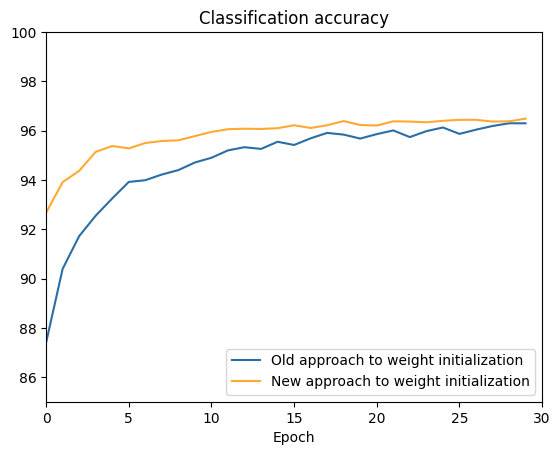

Train the network using the default starting weights.
Epoch 0 training complete
Accuracy on evaluation data: 9305 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9479 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9538 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9631 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9662 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9672 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9694 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9705 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9713 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9724 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9737 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9743 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9746 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 974

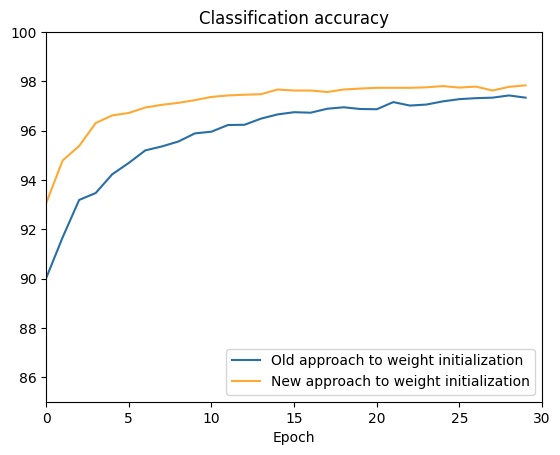

In [ ]:
# @title
"""weight_initialization
~~~~~~~~~~~~~~~~~~~~~~~~

This program shows how weight initialization affects training.  In
particular, we'll plot out how the classification accuracies improve
using either large starting weights, whose standard deviation is 1, or
the default starting weights, whose standard deviation is 1 over the
square root of the number of input neurons.

"""

# Standard library
import json
import random
import sys

# My library
sys.path.append('../src/')
import mnist_loader
# import network2

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

def main(filename, n, eta):
    run_network(filename, n, eta)
    make_plot(filename)

def run_network(filename, n, eta):
    """Train the network using both the default and the large starting
    weights.  Store the results in the file with name ``filename``,
    where they can later be used by ``make_plots``.

    """
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

    # Convert data to lists
    training_data = list(training_data)
    validation_data = list(validation_data)
    test_data = list(test_data)

    net = Network2mat([784, n, 10], cost=CrossEntropyCost)
    print("Train the network using the default starting weights.")
    default_vc, default_va, default_tc, default_ta \
        = net.SGD(training_data, 30, 10, eta, lmbda=5.0,
                  evaluation_data=validation_data,
                  monitor_evaluation_accuracy=True)
    print("Train the network using the large starting weights.")
    net.large_weight_initializer()
    large_vc, large_va, large_tc, large_ta \
        = net.SGD(training_data, 30, 10, eta, lmbda=5.0,
                  evaluation_data=validation_data,
                  monitor_evaluation_accuracy=True)
    f = open(filename, "w")
    json.dump({"default_weight_initialization":
               [default_vc, default_va, default_tc, default_ta],
               "large_weight_initialization":
               [large_vc, large_va, large_tc, large_ta]},
              f)
    f.close()

def make_plot(filename):
    """Load the results from the file ``filename``, and generate the
    corresponding plot.

    """
    f = open(filename, "r")
    results = json.load(f)
    f.close()
    default_vc, default_va, default_tc, default_ta = results[
        "default_weight_initialization"]
    large_vc, large_va, large_tc, large_ta = results[
        "large_weight_initialization"]
    # Convert raw classification numbers to percentages, for plotting
    default_va = [x/100.0 for x in default_va]
    large_va = [x/100.0 for x in large_va]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(0, 30, 1), large_va, color='#2A6EA6',
            label="Old approach to weight initialization")
    ax.plot(np.arange(0, 30, 1), default_va, color='#FFA933',
            label="New approach to weight initialization")
    ax.set_xlim([0, 30])
    ax.set_xlabel('Epoch')
    ax.set_ylim([85, 100])
    ax.set_title('Classification accuracy')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    main("weight_initialization_30.json", 30, 0.1)
    main("weight_initialization_100.json", 100, 0.1)

----
I stated above that we'll continue to initialize the biases as before,
as Gaussian random variables with a mean of $0$ and a standard deviation
of $1$. This is okay, because it doesn't make it too much more likely
that our neurons will saturate. In fact, it doesn't much matter how we
initialize the biases, provided we avoid the problem with saturation.
Some people go so far as to initialize all the biases to $0$, and rely
on gradient descent to learn appropriate biases. But since it's unlikely
to make much difference, we'll continue with the same initialization
procedure as before.

Let's compare the results for both our old and new approaches to weight
initialization, using the MNIST digit classification task

---

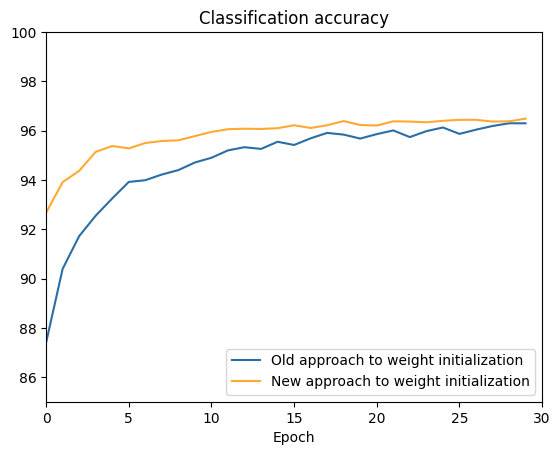

In [ ]:
make_plot("/content/weight_initialization_30.json")

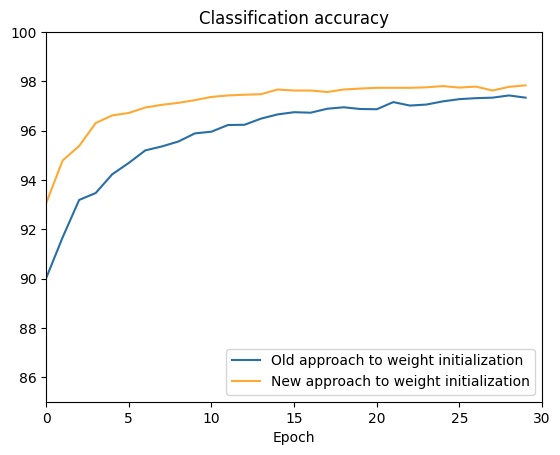

In [ ]:
make_plot("/content/weight_initialization_100.json")

---
In both cases in the plots above, we end up with a classification accuracy somewhat over $96\%$. The final classification accuracy is almost exactly the same in the two cases. But the new initialization technique brings us there
much, much faster. <u>At the end of the first epoch of training the old
approach to weight initialization has a classification accuracy under $87\%$, while the new approach is already almost $93\%$.</u> Our new approach to weight initialization starts us off in a much better regime, which lets us get good results much more quickly.

The same phenomenon is also seen if we plot results with $100$ hidden neurons.In this case, the two curves don't quite meet. However, my experiments
suggest that with just a few more epochs of training (not shown) the
accuracies become almost exactly the same. So on the basis of these
experiments it looks as though the improved weight initialization only
speeds up learning, it doesn't change the final performance of our
networks. However, in [Chapter 4](http://neuralnetworksanddeeplearning.com/chap4.html) we'll see examples of neural networks
where the long-run behaviour is significantly better with the
$1/\sqrt{n_{\rm in}}$ weight initialization. Thus it's not only the
speed of learning which is improved, it's sometimes also the final
performance.

The $1/\sqrt{n_{\rm in}}$ approach to weight initialization helps
improve the way our neural nets learn. Other techniques for weight
initialization have also been proposed, many building on this basic
idea. I won't review the other approaches here, since $1/\sqrt{n_{\rm in}}$ works well enough for our purposes. If you're interested in looking further, I recommend looking at the discussion on pages 14 and 15 of a 2012 paper by Yoshua Bengio**[10]**, as well as the references therein.
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
10. _[Practical Recommendations for Gradient-Based Training of Deep
Architectures](http://arxiv.org/pdf/1206.5533v2.pdf), by Yoshua Bengio
(2012)._

In [ ]:
%%time
# Load data
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

# Convert data to lists
training_data = list(training_data)
test_data = list(test_data)

# Initialize and train network
net = Network2mat([784, 30, 10], cost=CrossEntropyCost, reg='l1')
net.SGD(training_data, 30, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9433 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9478 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9468 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9506 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9495 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9526 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9523 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9530 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9572 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9531 / 10000
Epoch 10 training complete
Accuracy on evaluation data: 9597 / 10000
Epoch 11 training complete
Accuracy on evaluation data: 9565 / 10000
Epoch 12 training complete
Accuracy on evaluation data: 9568 / 10000
Epoch 13 training complete
Accuracy on evaluation data: 9576 / 10000
Epoch 14 training complete
Accuracy on evalu

([],
 [9433,
  9478,
  9468,
  9506,
  9495,
  9526,
  9523,
  9530,
  9572,
  9531,
  9597,
  9565,
  9568,
  9576,
  9553,
  9570,
  9548,
  9542,
  9535,
  9575,
  9560,
  9600,
  9546,
  9586,
  9545,
  9540,
  9574,
  9563,
  9585,
  9576],
 [],
 [])

## Fully Matrix-Based Backprop (`n_hidden` = 30) with **L1 regularization**: **`95.76%`** Accuracy

----
# How to choose a NN's hyperparameters?



---
The section discusses strategies for choosing neural network hyper-parameters like learning rate (η), regularization parameter (λ), and others, which can be challenging without prior experience. Initially, hyper-parameter selection may seem random, leading to poor results such as training a network that fails to learn and behaves like random noise. To address this, the author suggests:

1. **Simplify the Problem**: Begin with a simpler task, like classifying fewer classes (e.g., distinguishing only 0s and 1s in the MNIST dataset). This reduces the dataset size and speeds up training, allowing faster experimentation.
   
2. **Simplify the Network**: Start with a simpler network architecture, such as using fewer hidden layers or neurons, and gradually build complexity.

3. **Increase Monitoring Frequency**: Instead of waiting until the end of each epoch to monitor performance, evaluate after smaller chunks of training data to get faster feedback, enabling quicker experimentation with different hyper-parameters.

4. **Iterate Methodically**: Adjust each hyper-parameter systematically. For example, after improving the learning rate, focus on regularization, architecture, and other parameters step-by-step.

5. **Early Stage Quick Feedback**: Prioritize quick experimentation in the early stages, even if it means simplifying the architecture or problem. The goal is to get any meaningful learning before fine-tuning for better performance.

The section concludes that finding good hyper-parameters takes time and patience, and getting started with meaningful learning is the hardest part. Once a signal is established, further tweaks and improvements can be made more efficiently.

---
## <u>Guide to Choosing Neural Network Hyper-parameters</u>

## Introduction
- Selecting appropriate hyper-parameters for neural networks can be challenging
- Poor choices can lead to random noise generation instead of learning

## Broad Strategy
1. Start by achieving any non-trivial learning (better than chance)
2. Simplify the problem:
   - Reduce dataset size (e.g., use only $0$s and $1$s for MNIST)
   - Use a simpler network architecture
3. Increase monitoring frequency:
   - Check performance more often (e.g., every $\text{1,000}%$ training images)
   - Use a smaller validation set for quicker estimates

## Experimental Approach
1. Start with a simplified setup
2. Adjust one hyper-parameter at a time
3. Monitor performance using held-out validation data
4. Gradually increase complexity and dataset size

## Key Hyper-parameters to Focus On
- Learning rate ($\eta$)
- Regularization parameter ($\lambda$)
- Mini-batch size ($m$)

## Tips
- Ensure quick feedback from experiments in the early stages
- Simplifying the problem and architecture can lead to faster progress
- Be patient and persistent, as finding the right hyper-parameters can take time
- Gradually decrease monitoring frequency as you fine-tune hyper-parameters

## Conclusion
Finding the right hyper-parameters is an iterative process that requires experimentation and patience. Starting with a simplified problem and gradually increasing complexity can help in achieving meaningful learning more quickly.

---


Train a network using eta = 0.025
Epoch 0 training complete
Cost on training data: 0.8770331897602134
Epoch 1 training complete
Cost on training data: 0.6800202379930531
Epoch 2 training complete
Cost on training data: 0.6013079806061424
Epoch 3 training complete
Cost on training data: 0.5527053739105007
Epoch 4 training complete
Cost on training data: 0.5179543849384399
Epoch 5 training complete
Cost on training data: 0.4955397040294193
Epoch 6 training complete
Cost on training data: 0.4745554137439946
Epoch 7 training complete
Cost on training data: 0.4587896115016323
Epoch 8 training complete
Cost on training data: 0.4444038098998699
Epoch 9 training complete
Cost on training data: 0.4317001615800511
Epoch 10 training complete
Cost on training data: 0.42276045930292666
Epoch 11 training complete
Cost on training data: 0.41366345768044344
Epoch 12 training complete
Cost on training data: 0.4052121487359579
Epoch 13 training complete
Cost on training data: 0.4011762531301635
Epoch 1

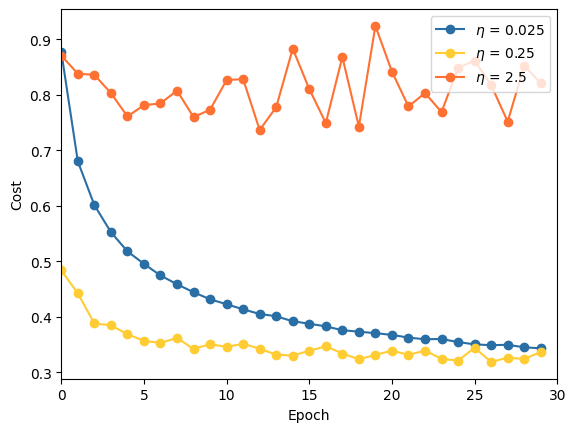

In [ ]:
"""multiple_eta
~~~~~~~~~~~~~~~

This program shows how different values for the learning rate affect
training.  In particular, we'll plot out how the cost changes using
three different values for eta.

"""

# Standard library
import json
import random
import sys

# My library
sys.path.append('../src/')
import mnist_loader
# import network2

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np

# Constants
LEARNING_RATES = [0.025, 0.25, 2.5]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
NUM_EPOCHS = 30

def main():
    run_networks()
    make_plot()

def run_networks():
    """Train networks using three different values for the learning rate,
    and store the cost curves in the file ``multiple_eta.json``, where
    they can later be used by ``make_plot``.

    """
    # Make results more easily reproducible
    random.seed(12345678)
    np.random.seed(12345678)
    training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

    # Convert data to lists
    training_data = list(training_data)
    validation_data = list(validation_data)
    test_data = list(test_data)

    results = []
    for eta in LEARNING_RATES:
        print("\nTrain a network using eta = "+str(eta))
        net = Network2mat([784, 30, 10])
        results.append(
            net.SGD(training_data, NUM_EPOCHS, 10, eta, lmbda=5.0,
                    evaluation_data=validation_data,
                    monitor_training_cost=True))
    f = open("multiple_eta.json", "w")
    json.dump(results, f)
    f.close()

def make_plot():
    f = open("multiple_eta.json", "r")
    results = json.load(f)
    f.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for eta, result, color in zip(LEARNING_RATES, results, COLORS):
        _, _, training_cost, _ = result
        ax.plot(np.arange(NUM_EPOCHS), training_cost, "o-",
                label="$\eta$ = "+str(eta),
                color=color)
    ax.set_xlim([0, NUM_EPOCHS])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')
    plt.legend(loc='upper right')
    plt.show()

if __name__ == "__main__":
    main()

---
**Learning rate:** Suppose we run three MNIST networks with three
different learning rates, $\eta = 0.025$, $\eta = 0.25$ and $\eta =
2.5$, respectively. We'll set the other hyper-parameters as for the
experiments in earlier sections, running over 30 epochs, with a
mini-batch size of 10, and with $\lambda = 5.0$. We'll also return to
using the full $50,000$ training images.

---

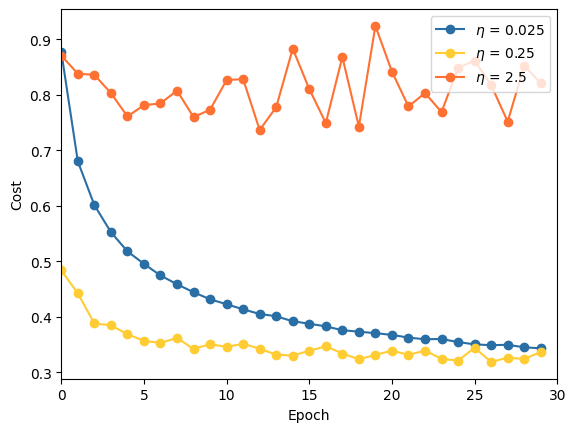

In [ ]:
make_plot()

---
With $\eta = 0.025$ the cost decreases smoothly until the final epoch.
With $\eta = 0.25$ the cost initially decreases, but after about $20$
epochs it is near saturation, and thereafter most of the changes are
merely small and apparently random oscillations. Finally, with $\eta =
2.5$ the cost makes large oscillations right from the start. To
understand the reason for the oscillations, recall that stochastic
gradient descent is supposed to step us gradually down into a valley of
the cost function,

![gradient descent valley cost function](https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/valley.png?raw=1)

However, if $\eta$ is too large then the steps will be so large that
they may actually overshoot the minimum, causing the algorithm to climb
up out of the valley instead. That's likely**[11]** what's causing the cost
to oscillate when $\eta = 2.5$. When we choose $\eta = 0.25$ the initial
steps do take us toward a minimum of the cost function, and it's only
once we get near that minimum that we start to suffer from the
overshooting problem. And when we choose $\eta = 0.025$ we don't suffer
from this problem at all during the first $30$ epochs. Of course,
choosing $\eta$ so small creates another problem, namely, that it slows
down stochastic gradient descent. An even better approach would be to
start with $\eta = 0.25$, train for $20$ epochs, and then switch to
$\eta = 0.025$. We'll discuss such variable learning rate schedules
later. For now, though, let's stick to figuring out how to find a single
good value for the learning rate, $\eta$.

With this picture in mind, we can set $\eta$ as follows. First, we
estimate the threshold value for $\eta$ at which the cost on the
training data immediately begins decreasing, instead of oscillating or
increasing. This estimate doesn't need to be too accurate. You can
estimate the order of magnitude by starting with $\eta = 0.01$. If the
cost decreases during the first few epochs, then you should successively
try $\eta = 0.1, 1.0, \ldots$ until you find a value for $\eta$ where
the cost oscillates or increases during the first few epochs.
Alternately, if the cost oscillates or increases during the first few
epochs when $\eta = 0.01$, then try $\eta = 0.001, 0.0001, \ldots$ until
you find a value for $\eta$ where the cost decreases during the first
few epochs. Following this procedure will give us an order of magnitude
estimate for the threshold value of $\eta$. You may optionally refine
your estimate, to pick out the largest value of $\eta$ at which the cost
decreases during the first few epochs, say $\eta = 0.5$ or $\eta = 0.2$
(there's no need for this to be super-accurate). This gives us an
estimate for the threshold value of $\eta$.

Obviously, the actual value of $\eta$ that you use should be no larger
than the threshold value. In fact, if the value of $\eta$ is to remain
usable over many epochs then you likely want to use a value for $\eta$
that is smaller, say, a factor of two below the threshold. Such a choice
will typically allow you to train for many epochs, without causing too
much of a slowdown in learning.

In the case of the MNIST data, following this strategy leads to an
estimate of $0.1$ for the order of magnitude of the threshold value of
$\eta$. After some more refinement, we obtain a threshold value $\eta =
0.5$. Following the prescription above, this suggests using $\eta =
0.25$ as our value for the learning rate. In fact, I found that using
$\eta = 0.5$ worked well enough over $30$ epochs that for the most part
I didn't worry about using a lower value of $\eta$.

This all seems quite straightforward. However, using the training cost
to pick $\eta$ appears to contradict what I said earlier in this
section, namely, that we'd pick hyper-parameters by evaluating
performance using our held-out validation data. In fact, we'll use
validation accuracy to pick the regularization hyper-parameter, the
mini-batch size, and network parameters such as the number of layers and
hidden neurons, and so on. Why do things differently for the learning
rate? Frankly, this choice is my personal aesthetic preference, and is
perhaps somewhat idiosyncratic. The reasoning is that the other
hyper-parameters are intended to improve the final classification
accuracy on the test set, and so it makes sense to select them on the
basis of validation accuracy. However, the learning rate is only
incidentally meant to impact the final classification accuracy. Its
primary purpose is really to control the step size in gradient descent,
and monitoring the training cost is the best way to detect if the step
size is too big. With that said, this is a personal aesthetic
preference. Early on during learning the training cost usually only
decreases if the validation accuracy improves, and so in practice it's
unlikely to make much difference which criterion you use.

----
**Use early stopping to determine the number of training epochs:** As we
discussed earlier in the chapter, early stopping means that at the end
of each epoch we should compute the classification accuracy on the
validation data. When that stops improving, terminate. This makes
setting the number of epochs very simple. In particular, it means that
we don't need to worry about explicitly figuring out how the number of
epochs depends on the other hyper-parameters. Instead, that's taken care
of automatically. Furthermore, early stopping also automatically
prevents us from overfitting. This is, of course, a good thing, although
in the early stages of experimentation it can be helpful to turn off
early stopping, so you can see any signs of overfitting, and use it to
inform your approach to regularization.

To implement early stopping we need to say more precisely what it means
that the classification accuracy has stopped improving. As we've seen,
the accuracy can jump around quite a bit, even when the overall trend is
to improve. If we stop the first time the accuracy decreases then we'll
almost certainly stop when there are more improvements to be had. A
better rule is to terminate if the best classification accuracy doesn't
improve for quite some time. Suppose, for example, that we're doing
MNIST. Then we might elect to terminate if the classification accuracy
hasn't improved during the last ten epochs. This ensures that we don't
stop too soon, in response to bad luck in training, but also that we're
not waiting around forever for an improvement that never comes.

This no-improvement-in-ten rule is good for initial exploration of
MNIST. However, networks can sometimes plateau near a particular
classification accuracy for quite some time, only to then begin
improving again. If you're trying to get really good performance, the
no-improvement-in-ten rule may be too aggressive about stopping. In that
case, I suggest using the no-improvement-in-ten rule for initial
experimentation, and gradually adopting more lenient rules, as you
better understand the way your network trains: no-improvement-in-twenty,
no-improvement-in-fifty, and so on. Of course, this introduces a new
hyper-parameter to optimize! In practice, however, it's usually easy to
set this hyper-parameter to get pretty good results. Similarly, for
problems other than MNIST, the no-improvement-in-ten rule may be much
too aggressive or not nearly aggressive enough, depending on the details
of the problem. However, with a little experimentation it's usually easy
to find a pretty good strategy for early stopping.

We haven't used early stopping in our MNIST experiments to date. The
reason is that we've been doing a lot of comparisons between different
approaches to learning. For such comparisons it's helpful to use the
same number of epochs in each case. However, it's well worth modifying
`Network2mat` to implement early stopping.

---
**Learning rate schedule:** We've been holding the learning rate $\eta$
constant. However, it's often advantageous to vary the learning rate.
Early on during the learning process it's likely that the weights are
badly wrong. And so it's best to use a large learning rate that causes
the weights to change quickly. Later, we can reduce the learning rate as
we make more fine-tuned adjustments to our weights.

How should we set our learning rate schedule? Many approaches are
possible. One natural approach is to use the same basic idea as early
stopping. The idea is to hold the learning rate constant until the
validation accuracy starts to get worse. Then decrease the learning rate
by some amount, say a factor of two or ten. We repeat this many times,
until, say, the learning rate is a factor of 1,024 (or 1,000) times
lower than the initial value. Then we terminate.

A variable learning schedule can improve performance, but it also opens
up a world of possible choices for the learning schedule. Those choices
can be a headache - you can spend forever trying to optimize your
learning schedule. For first experiments my suggestion is to use a
single, constant value for the learning rate. That'll get you a good
first approximation. Later, if you want to obtain the best performance
from your network, it's worth experimenting with a learning schedule,
along the lines I've described**[12]**.

---
**The regularization parameter, $\lambda$:** I suggest starting
initially with no regularization ($\lambda = 0.0$), and determining a
value for $\eta$, as above. Using that choice of $\eta$, we can then use
the validation data to select a good value for $\lambda$. Start by
trialing $\lambda = 1.0$ **[13]**, and then increase or decrease by factors of $10$, as needed to improve performance on the validation data. Once you've found a good order of magnitude, you can fine tune your value of $\lambda$. That done, you should return and re-optimize $\eta$ again.

---
**How I selected hyper-parameters earlier in this book:** If you use the
recommendations in this section you'll find that you get values for
$\eta$ and $\lambda$ which don't always exactly match the values I've
used earlier in the book. The reason is that the book has narrative
constraints that have sometimes made it impractical to optimize the
hyper-parameters. Think of all the comparisons we've made of different
approaches to learning, e.g., comparing the quadratic and cross-entropy
cost functions, comparing the old and new methods of weight
initialization, running with and without regularization, and so on. To
make such comparisons meaningful, I've usually tried to keep
hyper-parameters constant across the approaches being compared (or to
scale them in an appropriate way). Of course, there's no reason for the
same hyper-parameters to be optimal for all the different approaches to
learning, so the hyper-parameters I've used are something of a
compromise.

As an alternative to this compromise, I could have tried to optimize the
heck out of the hyper-parameters for every single approach to learning.
In principle that'd be a better, fairer approach, since then we'd see
the best from every approach to learning. However, we've made dozens of
comparisons along these lines, and in practice I found it too
computationally expensive. That's why I've adopted the compromise of
using pretty good (but not necessarily optimal) choices for the
hyper-parameters.

---
**Mini-batch size:** How should we set the mini-batch size? To answer
this question, let's first suppose that we're doing online learning,
i.e., that we're using a mini-batch size of $1$.

The obvious worry about online learning is that using mini-batches which
contain just a single training example will cause significant errors in
our estimate of the gradient. In fact, though, the errors turn out to
not be such a problem. The reason is that the individual gradient
estimates don't need to be super-accurate. All we need is an estimate
accurate enough that our cost function tends to keep decreasing. It's as
though you are trying to get to the North Magnetic Pole, but have a
wonky compass that's 10-20 degrees off each time you look at it.
Provided you stop to check the compass frequently, and the compass gets
the direction right on average, you'll end up at the North Magnetic Pole
just fine.

Based on this argument, it sounds as though we should use online
learning. In fact, the situation turns out to be more complicated than
that. In a [problem in the last chapter](http://neuralnetworksanddeeplearning.com/chap2.html#backprop_over_minibatch) I pointed out that it's
possible to use matrix techniques to compute the gradient update for
*all* examples in a mini-batch simultaneously, rather than looping over
them. Depending on the details of your hardware and linear algebra
library this can make it quite a bit faster to compute the gradient
estimate for a mini-batch of (for example) size $100$, rather than
computing the mini-batch gradient estimate by looping over the $100$
training examples separately. It might take (say) only $50$ times as
long, rather than $100$ times as long.

Now, at first it seems as though this doesn't help us that much. With
our mini-batch of size $100$ the learning rule for the weights looks
like:

<span id="eqtn15" class="displaced_anchor"></span>
\begin{eqnarray}
w \rightarrow w' = w-\eta \frac{1}{100} \sum_x \nabla C_x,
\tag{15}
\end{eqnarray}

where the sum is over training examples in the mini-batch. This is versus

<span id="eqtn16" class="displaced_anchor"></span>
\begin{eqnarray}
w \rightarrow w' = w-\eta \nabla C_x
\tag{16}
\end{eqnarray}

for online learning. Even if it only takes $50$ times as long to do the mini-batch update, it still seems likely to be better to do online learning,
because we'd be updating so much more frequently. Suppose, however, that
in the mini-batch case we increase the learning rate by a factor $100$,
so the update rule becomes

<span id="eqtn17" class="displaced_anchor"></span>
\begin{eqnarray}
w \rightarrow w' = w-\eta \sum_x \nabla C_x.
\tag{17}
\end{eqnarray}

That's a lot like doing $100$ separate instances of online learning with a learning rate of $\eta$. But it only takes $50$ times as long as doing a single
instance of online learning. Of course, it's not truly the same as $100$
instances of online learning, since in the mini-batch the $\nabla C_x$'s
are all evaluated for the same set of weights, as opposed to the cumulative learning that occurs in the online case. Still, it seems distinctly possible that using the larger mini-batch would speed things up.

With these factors in mind, choosing the best mini-batch size is a
compromise. Too small, and you don't get to take full advantage of the
benefits of good matrix libraries optimized for fast hardware. Too large
and you're simply not updating your weights often enough. What you need
is to choose a compromise value which maximizes the speed of learning.
Fortunately, the choice of mini-batch size at which the speed is
maximized is relatively independent of the other hyper-parameters (apart
from the overall architecture), so you don't need to have optimized
those hyper-parameters in order to find a good mini-batch size. The way
to go is therefore to use some acceptable (but not necessarily optimal)
values for the other hyper-parameters, and then trial a number of
different mini-batch sizes, scaling $\eta$ as above. Plot the validation
accuracy versus *time* (as in, real elapsed time, not epoch!), and
choose whichever mini-batch size gives you the most rapid improvement in
performance. With the mini-batch size chosen you can then proceed to
optimize the other hyper-parameters.

Of course, as you've no doubt realized, I haven't done this optimization
in our work. Indeed, our implementation doesn't use the faster approach
to mini-batch updates at all. I've simply used a mini-batch size of $10$
without comment or explanation in nearly all examples. Because of this,
we could have sped up learning by reducing the mini-batch size. I
haven't done this, in part because I wanted to illustrate the use of
mini-batches beyond size $1$, and in part because my preliminary
experiments suggested the speedup would be rather modest. In practical
implementations, however, we would most certainly implement the faster
approach to mini-batch updates, and then make an effort to optimize the
mini-batch size, in order to maximize our overall speed.

---
**Automated techniques:** I've been describing these heuristics as
though you're optimizing your hyper-parameters by hand.
Hand-optimization is a good way to build up a feel for how neural
networks behave. However, and unsurprisingly, a great deal of work has
been done on automating the process. A common technique is *grid
search*, which systematically searches through a grid in hyper-parameter
space. A review of both the achievements and the limitations of grid
search (with suggestions for easily-implemented alternatives) may be
found in a 2012 paper**[14]** by James Bergstra and Yoshua
Bengio. Many more sophisticated approaches have also been proposed. I
won't review all that work here, but do want to mention a particularly
promising 2012 paper which used a Bayesian approach to automatically
optimize hyper-parameters**[15]**. The code from the paper is [publicly available](https://github.com/jaberg/hyperopt), and has been used with some success by other researchers.

---
**Summing up:** Following the rules-of-thumb I've described won't give
you the absolute best possible results from your neural network. But it
will likely give you a good start and a basis for further improvements.
In particular, I've discussed the hyper-parameters largely
independently. In practice, there are relationships between the
hyper-parameters. You may experiment with $\eta$, feel that you've got
it just right, then start to optimize for $\lambda$, only to find that
it's messing up your optimization for $\eta$. In practice, it helps to
bounce backward and forward, gradually closing in good values. Above
all, keep in mind that the heuristics I've described are rules of thumb,
not rules cast in stone. You should be on the lookout for signs that
things aren't working, and be willing to experiment. In particular, this
means carefully monitoring your network's behaviour, especially the
validation accuracy.

The difficulty of choosing hyper-parameters is exacerbated by the fact
that the lore about how to choose hyper-parameters is widely spread,
across many research papers and software programs, and often is only
available inside the heads of individual practitioners. There are many,
many papers setting out (sometimes contradictory) recommendations for
how to proceed. However, there are a few particularly useful papers that
synthesize and distill out much of this lore. Yoshua Bengio has a 2012
paper**[16]** that gives some practical recommendations for using
backpropagation and gradient descent to train neural networks, including
deep neural nets. Bengio discusses many issues in much more detail than
I have, including how to do more systematic hyper-parameter searches.
Another good paper is a 1998 paper**[17]** by Yann LeCun, Léon Bottou, Genevieve Orr and Klaus-Robert Müller. Both these papers appear in an extremely useful 2012 book that collects many tricks commonly used in neural nets**[18]**. The book is expensive, but many of the articles have
been placed online by their respective authors with, one presumes, the
blessing of the publisher, and may be located using a search engine.

One thing that becomes clear as you read these articles and, especially,
as you engage in your own experiments, is that hyper-parameter
optimization is not a problem that is ever completely solved. There's
always another trick you can try to improve performance. There is a
saying common among writers that books are never finished, only
abandoned. The same is also true of neural network optimization: the
space of hyper-parameters is so large that one never really finishes
optimizing, one only abandons the network to posterity. So your goal
should be to develop a workflow that enables you to quickly do a pretty
good job on the optimization, while leaving you the flexibility to try
more detailed optimizations, if that's important.

The challenge of setting hyper-parameters has led some people to
complain that neural networks require a lot of work when compared with
other machine learning techniques. I've heard many variations on the
following complaint: "Yes, a well-tuned neural network may get the best
performance on the problem. On the other hand, I can try a random forest
\[or SVM or$\ldots$ insert your own favorite technique\] and it just
works. I don't have time to figure out just the right neural network."
Of course, from a practical point of view it's good to have
easy-to-apply techniques. This is particularly true when you're just
getting started on a problem, and it may not be obvious whether machine
learning can help solve the problem at all. On the other hand, if
getting optimal performance is important, then you may need to try
approaches that require more specialist knowledge. While it would be
nice if machine learning were always easy, there is no *a priori* reason
it should be trivially simple.
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
11. _This picture is helpful, but it's intended as an intuition-building
illustration of what may go on, not as a complete, exhaustive
explanation. Briefly, a more complete explanation is as follows:
gradient descent uses a first-order approximation to the cost function
as a guide to how to decrease the cost. For large $\eta$, higher-order
terms in the cost function become more important, and may dominate the
behaviour, causing gradient descent to break down. This is especially
likely as we approach minima and quasi-minima of the cost function,
since near such points the gradient becomes small, making it easier for
higher-order terms to dominate behaviour._<br>
12. _A readable recent paper which demonstrates the benefits of variable learning rates in attacking MNIST is [Deep, Big, Simple Neural Nets Excel on
Handwritten Digit Recognition](http://arxiv.org/abs/1003.0358), by Dan
Claudiu Cireșan, Ueli Meier, Luca Maria Gambardella, and Jürgen
Schmidhuber (2010)._<br>
13. _I don't have a good principled justification for using this as a starting value. If anyone knows of a good principled discussion of where to start with
$\lambda$, I'd appreciate hearing it (mn@michaelnielsen.org)_<br>
14. _[Random search for hyper-parameter optimization](http://dl.acm.org/citation.cfm?id=2188395), by James Bergstra and Yoshua Bengio (2012)._<br>
15. _[Practical Bayesian optimization of machine learning algorithms](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf),
by Jasper Snoek, Hugo Larochelle, and Ryan Adams._<br>
16. _[Practical recommendations for gradient-based training of deep
architectures](http://arxiv.org/abs/1206.5533), by Yoshua Bengio (2012)._<br>
17. _[Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), by Yann LeCun, Léon Bottou, Genevieve Orr and Klaus-Robert Müller (1998)._<br>
18. _[Neural Networks: Tricks of the Trade](http://www.springer.com/computer/theoretical+computer+science/book/978-3-642-35288-1), edited by Grégoire Montavon, Geneviève Orr, and Klaus-Robert Müller._

In [ ]:
# @title
"""network2mat2.py
~~~~~~~~~~~~~~

An improved version of network2mat.py, that adds early stopping.

"""

#### Main Network class
class Network2mat2(object):

    def __init__(self, sizes, cost=CrossEntropyCost, reg='l2'):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
        self.reg = reg

    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0, evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n=10):
        """
        Train the neural network using mini-batch stochastic gradient descent with
        early stopping. Early stopping is triggered if the performance on the
        evaluation data does not improve for 'early_stopping_n' consecutive epochs.

        Parameters:
        - early_stopping_n: The number of epochs to wait for improvement before stopping
        """
        if evaluation_data:
            n_data = len(list(evaluation_data))
        n = len(list(training_data))

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []

        best_evaluation_accuracy = 0
        best_evaluation_cost = float('inf')
        epochs_without_improvement = 0

        for j in range(epochs):
            # Shuffle and create mini-batches
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]

            # Update weights and biases using each mini-batch
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, n)

            print(f"Epoch {j} training complete")

            # Monitor cost/accuracy if required
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print(f"Cost on training data: {cost}")
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print(f"Accuracy on training data: {accuracy} / {n}")
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print(f"Cost on evaluation data: {cost}")
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print(f"Accuracy on evaluation data: {accuracy} / {n_data}")

            # Early stopping logic based on evaluation accuracy or cost
            if monitor_evaluation_accuracy:
                if accuracy > best_evaluation_accuracy:
                    best_evaluation_accuracy = accuracy
                    epochs_without_improvement = 0  # Reset counter if we see improvement
                else:
                    epochs_without_improvement += 1

            elif monitor_evaluation_cost:
                if cost < best_evaluation_cost:
                    best_evaluation_cost = cost
                    epochs_without_improvement = 0  # Reset counter if we see improvement
                else:
                    epochs_without_improvement += 1

            # Check for early stopping condition
            if epochs_without_improvement >= early_stopping_n:
                print(f"Early stopping after {j+1} epochs due to no improvement for {early_stopping_n} epochs.")
                break  # Exit the training loop

        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient descent
        using backpropagation to a single mini-batch."""

        # Convert the mini-batch into matrix form
        X = np.column_stack([x for x, y in mini_batch])
        Y = np.column_stack([y for x, y in mini_batch])

        # Perform forward and backward passes
        nabla_b, nabla_w = self.backprop_matrix(X, Y)

        # Update weights and biases using gradient descent and L1 or L2 regularization
        if self.reg == 'l2':
          self.weights = [(1 - eta * (lmbda/n)) * w - (eta/len(mini_batch)) * nw
                          for w, nw in zip(self.weights, nabla_w)]
        elif self.reg == 'l1':
          self.weights = [w - (eta * (lmbda/n)) * np.sign(w) - (eta / len(mini_batch)) * nw
                          for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                      for b, nb in zip(self.biases, nabla_b)]


    def backprop_matrix(self, X, Y):
        """Matrix-based backpropagation for a mini-batch."""

        # Initialize gradients
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Step 1: Forward pass
        activation = X
        activations = [X]  # Store all activations layer by layer
        zs = []  # Store all z vectors layer by layer

        # Feedforward step through all layers
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # Step 2: Backward pass

        # Compute delta at the output layer
        delta = self.cost.delta(zs[-1], activations[-1], Y)

        # Gradients for the output layer
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate through previous layers
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, activations[-l-1].T)

        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        if self.reg == 'l2':
          cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        elif self.reg == 'l1':
          cost += (lmbda/len(data))*sum(np.linalg.norm(w, ord=1) for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

In [ ]:
# @title
"""network2mat3.py
~~~~~~~~~~~~~~

An improved version of network2mat2.py, that adds
New Early Stopping Rule: Relative Improvement Below Threshold.

"""

#### Main Network class
class Network2mat3(object):

    def __init__(self, sizes, cost=CrossEntropyCost, reg='l2'):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
        self.reg = reg

    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a


    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda=0.0, evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n=10, relative_improvement_threshold=0.01):
        """
        Train the neural network using mini-batch stochastic gradient descent with
        early stopping. There are two stopping criteria:
        - No-improvement-in-n: Stop if there is no improvement in performance for `n` epochs.
        - Relative improvement threshold: Stop if the improvement is smaller than the threshold.

        Parameters:
        - early_stopping_n: The number of epochs to wait for improvement before stopping.
        - relative_improvement_threshold: The minimum relative improvement required between epochs.
        """
        if evaluation_data:
            n_data = len(list(evaluation_data))
        n = len(list(training_data))

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []

        best_evaluation_accuracy = 0
        best_evaluation_cost = float('inf')
        epochs_without_improvement = 0
        previous_accuracy = 0
        previous_cost = float('inf')

        for j in range(epochs):
            # Shuffle and create mini-batches
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]

            # Update weights and biases using each mini-batch
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, n)

            print(f"Epoch {j} training complete")

            # Monitor cost/accuracy if required
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print(f"Cost on training data: {cost}")
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print(f"Accuracy on training data: {accuracy} / {n}")
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print(f"Cost on evaluation data: {cost}")
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print(f"Accuracy on evaluation data: {accuracy} / {n_data}")

            # Early stopping logic based on no-improvement-in-n or relative improvement
            if monitor_evaluation_accuracy:
                relative_improvement = abs((accuracy - previous_accuracy) / (previous_accuracy + 1e-8))  # avoid division by zero

                if accuracy > best_evaluation_accuracy:
                    best_evaluation_accuracy = accuracy
                    epochs_without_improvement = 0  # Reset counter if we see improvement
                else:
                    epochs_without_improvement += 1

                # Relative improvement check
                if relative_improvement < relative_improvement_threshold:
                    print(f"Early stopping after {j+1} epochs due to relative improvement threshold on eval. accuracy: \n{relative_improvement:.6f} < {relative_improvement_threshold}")
                    break  # Stop if relative improvement is small

                previous_accuracy = accuracy  # Update the previous accuracy for next iteration

            elif monitor_evaluation_cost:
                relative_improvement = abs((cost - previous_cost) / (previous_cost + 1e-8))  # avoid division by zero

                if cost < best_evaluation_cost:
                    best_evaluation_cost = cost
                    epochs_without_improvement = 0  # Reset counter if we see improvement
                else:
                    epochs_without_improvement += 1

                # Relative improvement check
                if relative_improvement < relative_improvement_threshold:
                    print(f"Early stopping after {j+1} epochs due to relative improvement threshold on eval. cost: \n{relative_improvement:.6f} < {relative_improvement_threshold}")
                    break  # Stop if relative improvement is small

                previous_cost = cost  # Update the previous cost for next iteration

            # No-improvement-in-n epochs check
            if epochs_without_improvement >= early_stopping_n:
                print(f"Early stopping after {j+1} epochs due to no improvement for {early_stopping_n} epochs.")
                break  # Exit the training loop

        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient descent
        using backpropagation to a single mini-batch."""

        # Convert the mini-batch into matrix form
        X = np.column_stack([x for x, y in mini_batch])
        Y = np.column_stack([y for x, y in mini_batch])

        # Perform forward and backward passes
        nabla_b, nabla_w = self.backprop_matrix(X, Y)

        # Update weights and biases using gradient descent and L1 or L2 regularization
        if self.reg == 'l2':
          self.weights = [(1 - eta * (lmbda/n)) * w - (eta/len(mini_batch)) * nw
                          for w, nw in zip(self.weights, nabla_w)]
        elif self.reg == 'l1':
          self.weights = [w - (eta * (lmbda/n)) * np.sign(w) - (eta / len(mini_batch)) * nw
                          for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                      for b, nb in zip(self.biases, nabla_b)]


    def backprop_matrix(self, X, Y):
        """Matrix-based backpropagation for a mini-batch."""

        # Initialize gradients
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Step 1: Forward pass
        activation = X
        activations = [X]  # Store all activations layer by layer
        zs = []  # Store all z vectors layer by layer

        # Feedforward step through all layers
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # Step 2: Backward pass

        # Compute delta at the output layer
        delta = self.cost.delta(zs[-1], activations[-1], Y)

        # Gradients for the output layer
        nabla_b[-1] = np.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate through previous layers
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            nabla_b[-l] = np.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = np.dot(delta, activations[-l-1].T)

        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        if self.reg == 'l2':
          cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        elif self.reg == 'l1':
          cost += (lmbda/len(data))*sum(np.linalg.norm(w, ord=1) for w in self.weights)
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

In [ ]:
%%time
# Initialize and train network
net = Network2mat2([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
eval_cost_n10, eval_acc_n10, train_cost_n10, train_acc_n10 = net.SGD(
        training_data, 30, 10, 0.5, 5, evaluation_data=test_data,
        monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
        early_stopping_n=10)

Epoch 0 training complete
Cost on evaluation data: 4.370084705653962
Accuracy on evaluation data: 9170 / 10000
Epoch 1 training complete
Cost on evaluation data: 2.952264492793333
Accuracy on evaluation data: 9315 / 10000
Epoch 2 training complete
Cost on evaluation data: 2.11608194188085
Accuracy on evaluation data: 9407 / 10000
Epoch 3 training complete
Cost on evaluation data: 1.6206092381096153
Accuracy on evaluation data: 9483 / 10000
Epoch 4 training complete
Cost on evaluation data: 1.338428694958743
Accuracy on evaluation data: 9517 / 10000
Epoch 5 training complete
Cost on evaluation data: 1.1792030229196118
Accuracy on evaluation data: 9502 / 10000
Epoch 6 training complete
Cost on evaluation data: 1.1349722093919958
Accuracy on evaluation data: 9434 / 10000
Epoch 7 training complete
Cost on evaluation data: 1.0295785208869956
Accuracy on evaluation data: 9550 / 10000
Epoch 8 training complete
Cost on evaluation data: 1.0377775762636152
Accuracy on evaluation data: 9487 / 100

In [ ]:
%%time
# Initialize and train network --> Relative Improvement Threshold (1%)
net = Network2mat3([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
eval_cost_res1p, eval_acc_res1p, train_cost_res1p, train_acc_res1p = net.SGD(
        training_data, 30, 10, 0.5, 5, evaluation_data=test_data,
        monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
        early_stopping_n=10, relative_improvement_threshold=0.01)

Epoch 0 training complete
Cost on evaluation data: 4.440950566645229
Accuracy on evaluation data: 9146 / 10000
Epoch 1 training complete
Cost on evaluation data: 2.986621201620257
Accuracy on evaluation data: 9310 / 10000
Epoch 2 training complete
Cost on evaluation data: 2.1155207226509374
Accuracy on evaluation data: 9447 / 10000
Epoch 3 training complete
Cost on evaluation data: 1.6304008007274098
Accuracy on evaluation data: 9466 / 10000
Early stopping after 4 epochs due to relative improvement threshold on eval. accuracy: 
0.002011 < 0.01
CPU times: user 15.6 s, sys: 6.39 s, total: 22 s
Wall time: 17.6 s


In [ ]:
%%time
# Initialize and train network --> Relative Improvement Threshold (0.05%)
net = Network2mat3([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
eval_cost_res2, eval_acc_res2, train_cost_res2, train_acc_res2 = net.SGD(
        training_data, 30, 10, 0.5, 5, evaluation_data=test_data,
        monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
        early_stopping_n=10, relative_improvement_threshold=0.0005)

Epoch 0 training complete
Cost on evaluation data: 4.308369597153946
Accuracy on evaluation data: 9208 / 10000
Epoch 1 training complete
Cost on evaluation data: 2.899905351508916
Accuracy on evaluation data: 9365 / 10000
Epoch 2 training complete
Cost on evaluation data: 2.099951867450372
Accuracy on evaluation data: 9418 / 10000
Epoch 3 training complete
Cost on evaluation data: 1.6281577096451232
Accuracy on evaluation data: 9452 / 10000
Epoch 4 training complete
Cost on evaluation data: 1.376248076408555
Accuracy on evaluation data: 9434 / 10000
Epoch 5 training complete
Cost on evaluation data: 1.1803890136870558
Accuracy on evaluation data: 9543 / 10000
Epoch 6 training complete
Cost on evaluation data: 1.1531647646034178
Accuracy on evaluation data: 9447 / 10000
Epoch 7 training complete
Cost on evaluation data: 1.0244347291990943
Accuracy on evaluation data: 9581 / 10000
Epoch 8 training complete
Cost on evaluation data: 1.0269805140377313
Accuracy on evaluation data: 9542 / 10

In [ ]:
%%time
# Initialize and train network --> Relative Improvement Threshold (0.007%)
net = Network2mat3([784, 30, 10], cost=CrossEntropyCost)
net.large_weight_initializer()
eval_cost_res3, eval_acc_res3, train_cost_res3, train_acc_res3 = net.SGD(
        training_data, 30, 10, 0.5, 5, evaluation_data=test_data,
        monitor_evaluation_cost=True, monitor_evaluation_accuracy=True,
        early_stopping_n=10, relative_improvement_threshold=0.00007)

Epoch 0 training complete
Cost on evaluation data: 4.391974338541706
Accuracy on evaluation data: 9122 / 10000
Epoch 1 training complete
Cost on evaluation data: 2.9557418621005933
Accuracy on evaluation data: 9314 / 10000
Epoch 2 training complete
Cost on evaluation data: 2.150090473942308
Accuracy on evaluation data: 9366 / 10000
Epoch 3 training complete
Cost on evaluation data: 1.6292553781691939
Accuracy on evaluation data: 9466 / 10000
Epoch 4 training complete
Cost on evaluation data: 1.3431368103123131
Accuracy on evaluation data: 9520 / 10000
Epoch 5 training complete
Cost on evaluation data: 1.2545291666155989
Accuracy on evaluation data: 9420 / 10000
Epoch 6 training complete
Cost on evaluation data: 1.087030835721143
Accuracy on evaluation data: 9549 / 10000
Epoch 7 training complete
Cost on evaluation data: 1.0558654702260977
Accuracy on evaluation data: 9513 / 10000
Epoch 8 training complete
Cost on evaluation data: 0.9914709204307675
Accuracy on evaluation data: 9580 / 1

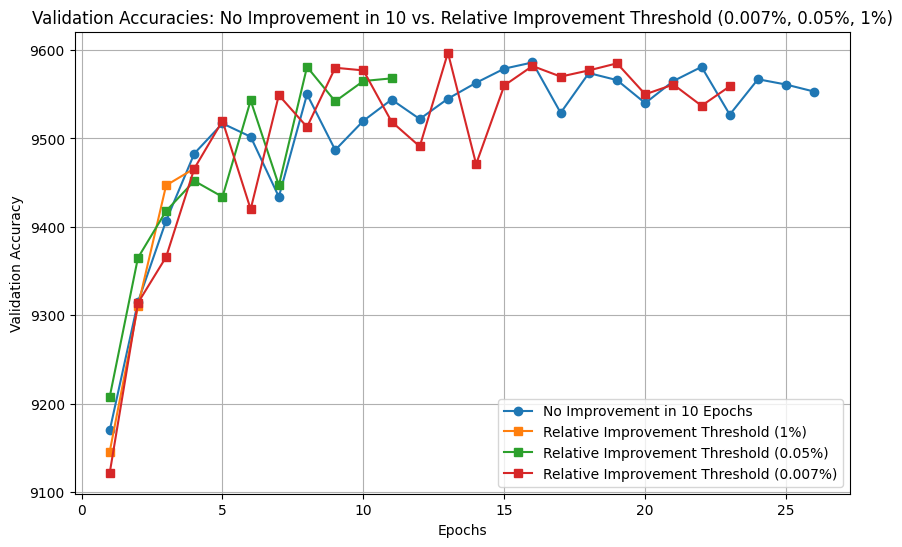

In [ ]:
epochs_n10 = list(range(1, len(eval_acc_n10) + 1))
epochs_res1p = list(range(1, len(eval_acc_res1p) + 1))
epochs_res2 = list(range(1, len(eval_acc_res2) + 1))
epochs_res3 = list(range(1, len(eval_acc_res3) + 1))

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs_n10, eval_acc_n10, label="No Improvement in 10 Epochs", marker='o')
plt.plot(epochs_res1p, eval_acc_res1p, label="Relative Improvement Threshold (1%)", marker='s')
plt.plot(epochs_res2, eval_acc_res2, label="Relative Improvement Threshold (0.05%)", marker='s')
plt.plot(epochs_res3, eval_acc_res3, label="Relative Improvement Threshold (0.007%)", marker='s')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracies: No Improvement in 10 vs. Relative Improvement Threshold (0.007%, 0.05%, 1%)")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

----
# Other techniques to improve NNs



---
Each technique developed in so far is valuable to know in its own
right, but that's not the only reason I've explained them. The larger
point is to familiarize you with some of the problems which can occur in
neural networks, and with a style of analysis which can help overcome
those problems. In a sense, we've been learning how to think about
neural nets. Over the remainder of this chapter I briefly sketch a
handful of other techniques. These sketches are less in-depth than the
earlier discussions, but should convey some feeling for the diversity of
techniques available for use in neural networks.


---
## Variations On SGD

Stochastic gradient descent (SGD) by backpropagation has served us well in
attacking the MNIST digit classification problem. However, there are
many other approaches to optimizing the cost function, and sometimes
those other approaches offer performance superior to mini-batch
stochastic gradient descent. In this section I sketch two such
approaches, the Hessian and momentum techniques.

**Hessian technique:** To begin our discussion it helps to put neural
networks aside for a bit. Instead, we're just going to consider the
abstract problem of minimizing a cost function $C$ which is a function
of many variables, $w = w_1, w_2, \ldots$, so $C = C(w)$. By Taylor's
theorem, the cost function can be approximated near a point $w$ by

<span id="eqtn18" class="displaced_anchor"></span>
\begin{eqnarray}
C(w+\Delta w) & = & C(w) + \sum_j \frac{\partial C}{\partial w_j} \Delta
w_j \nonumber \\ & & + \frac{1}{2} \sum\_{jk} \Delta w_j
\frac{\partial^2 C}{\partial w_j \partial w_k} \Delta w_k + \ldots
\tag{18}
\end{eqnarray}

We can rewrite this more compactly as

<span id="eqtn19" class="displaced_anchor"></span>
\begin{eqnarray}
C(w+\Delta w) = C(w) + \nabla C \cdot \Delta w + \frac{1}{2} \Delta w^T
H \Delta w + \ldots,
\tag{19}
\end{eqnarray}

where $\nabla C$ is the usual gradient vector, and $H$ is a matrix known as the *Hessian matrix*, whose $jk$th entry is $\partial^2 C / \partial w_j \partial
w_k$. Suppose we approximate $C$ by discarding the higher-order terms
represented by $\ldots$ above,
<span id="eqtn20" class="displaced_anchor"></span>
\begin{eqnarray}
C(w+\Delta w) \approx
C(w) + \nabla C \cdot \Delta w + \frac{1}{2} \Delta w^T H \Delta w.
\tag{20}
\end{eqnarray}

Using calculus we can show that the expression on the right-hand side can be minimized**[19]** by choosing

<span id="eqtn21" class="displaced_anchor"></span>
\begin{eqnarray}
\Delta w = -H^{-1} \nabla C.
\tag{21}
\end{eqnarray}

Provided **Equation (20)** is a good approximate expression for the cost function, then we'd expect that moving from the point $w$ to $w+\Delta w = w-H^{-1} \nabla C$ should significantly decrease the cost function. That suggests a
possible algorithm for minimizing the cost:

-   Choose a starting point, $w$.
-   Update $w$ to a new point $w' = w-H^{-1} \nabla C$, where the Hessian $H$ and $\nabla C$ are computed at $w$.
-   Update $w'$ to a new point $w{'}{'} = w'-H'^{-1} \nabla' C$, where the Hessian $H'$ and $\nabla' C$ are computed at $w'$.
-   $\ldots$

In practice, **Equation (20)** is only an approximation, and it's better to take smaller steps. We do this by repeatedly changing $w$ by an amount $\Delta w = -\eta H^{-1} \nabla C$, where $\eta$ is known as the *learning rate*.

This approach to minimizing a cost function is known as the _**Hessian
technique**_ or _**Hessian optimization.**_ There are theoretical and
empirical results showing that Hessian methods converge on a minimum in
fewer steps than standard gradient descent. In particular, by
incorporating information about second-order changes in the cost
function it's possible for the Hessian approach to avoid many
pathologies that can occur in gradient descent. Furthermore, there are
versions of the backpropagation algorithm which can be used to compute
the Hessian.

If Hessian optimization is so great, why aren't we using it in our
neural networks? Unfortunately, while it has many desirable properties,
it has one very undesirable property: it's very difficult to apply in
practice. Part of the problem is the sheer size of the Hessian matrix.
Suppose you have a neural network with $10^7$ weights and biases. Then
the corresponding Hessian matrix will contain $10^7 \times 10^7 =
10^{14}$ entries. That's a lot of entries! And that makes computing
$H^{-1} \nabla C$ extremely difficult in practice. However, that doesn't
mean that it's not useful to understand. In fact, there are many
variations on gradient descent which are inspired by Hessian
optimization, but which avoid the problem with overly-large matrices.
Let's take a look at one such technique, momentum-based gradient
descent.


**Momentum-based gradient descent:** Intuitively, the advantage Hessian
optimization has is that it incorporates not just information about the
gradient, but also information about how the gradient is changing.
Momentum-based gradient descent is based on a similar intuition, but
avoids large matrices of second derivatives. To understand the momentum
technique, think back to our [original picture](http://neuralnetworksanddeeplearning.com/chap1.html#gradient_descent) of gradient descent, in which we considered a ball rolling down into a valley. At the time, we observed that gradient descent is, despite its name, only loosely similar to a ball falling to the bottom of a valley. The momentum technique modifies
gradient descent in two ways that make it more similar to the physical
picture. First, it introduces a notion of "velocity" for the parameters
we're trying to optimize. The gradient acts to change the velocity, not
(directly) the "position", in much the same way as physical forces
change the velocity, and only indirectly affect position. Second, the
momentum method introduces a kind of friction term, which tends to
gradually reduce the velocity.

Let's give a more precise mathematical description. We introduce
velocity variables $v = v_1, v_2, \ldots$, one for each corresponding
$w_j$ variable**[20]**. Then we replace the gradient descent update rule $w \rightarrow w'= w-\eta \nabla C$ by

<span id="eqtn22" class="displaced_anchor"></span>
<span id="eqtn23" class="displaced_anchor"></span>
\begin{eqnarray}
v & \rightarrow & v' = \mu v - \eta \nabla C
\tag{22}
\\
w & \rightarrow & w' = w+v'.
\tag{23}
\end{eqnarray}

In these equations, $\mu$ is a hyper-parameter which controls the amount of damping or friction in the system. To understand the meaning of the equations it's helpful to first consider the case where $\mu = 1$, which corresponds to no friction. When that's the case, inspection of the equations shows that the "force" $\nabla C$ is now modifying the velocity, $v$, and the velocity is controlling the rate of change of $w$. Intuitively, we build up the velocity by
repeatedly adding gradient terms to it. That means that if the gradient
is in (roughly) the same direction through several rounds of learning,
we can build up quite a bit of steam moving in that direction. Think,
for example, of what happens if we're moving straight down a slope:

![gradient descent valley cost function](https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/valley.png?raw=1)

With each step the velocity gets larger down the slope, so we move more
and more quickly to the bottom of the valley. This can enable the
momentum technique to work much faster than standard gradient descent.
Of course, a problem is that once we reach the bottom of the valley we
will overshoot. Or, if the gradient should change rapidly, then we could
find ourselves moving in the wrong direction. That's the reason for the
$\mu$ hyper-parameter in **Equation (22)**. I said earlier that $\mu$ controls the amount of friction in the system; to be a little more precise, you should think of $1-\mu$ as the amount of friction in the system. When $\mu = 1$, as we've seen, there is no friction, and the velocity is completely driven by the gradient $\nabla C$. By contrast, when $\mu = 0$ there's a lot of friction, the
velocity can't build up, and **Equations (22) and (23)**
reduce to the usual equation for gradient descent, $w \rightarrow
w'=w-\eta \nabla C$. In practice, using a value of $\mu$ intermediate
between $0$ and $1$ can give us much of the benefit of being able to
build up speed, but without causing overshooting. We can choose such a
value for $\mu$ using the held-out validation data, in much the same way
as we select $\eta$ and $\lambda$.

I've avoided naming the hyper-parameter $\mu$ up to now. The reason is
that the standard name for $\mu$ is badly chosen: it's called the
_**momentum co-efficient**_. This is potentially confusing, since $\mu$ is
not at all the same as the notion of momentum from physics. Rather, it
is much more closely related to friction. However, the term momentum
co-efficient is widely used, so we will continue to use it.

A nice thing about the momentum technique is that it takes almost no
work to modify an implementation of gradient descent to incorporate
momentum. We can still use backpropagation to compute the gradients,
just as before, and use ideas such as sampling stochastically chosen
mini-batches. In this way, we can get some of the advantages of the
Hessian technique, using information about how the gradient is changing.
But it's done without the disadvantages, and with only minor
modifications to our code. In practice, the momentum technique is
commonly used, and often speeds up learning.


**Other approaches to minimizing the cost function:** Many other
approaches to minimizing the cost function have been developed, and
there isn't universal agreement on which is the best approach. As you go
deeper into neural networks it's worth digging into the other
techniques, understanding how they work, their strengths and weaknesses,
and how to apply them in practice. A paper I mentioned earlier**[21]** introduces and compares several of these techniques, including
- **conjugate gradient descent** and
- the **BFGS** method (see also the closely related limited-memory BFGS method, known as [L-BFGS](http://en.wikipedia.org/wiki/Limited-memory_BFGS)).
- Another technique which has recently shown promising results**[22]** is **Nesterov's accelerated gradient** technique, which improves on the momentum technique.

However, for many problems, plain stochastic gradient descent works well, especially if momentum is used, and so we'll stick to stochastic gradient descent through the remainder of the course.
<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
19. _Strictly speaking, for this to be a minimum, and not merely an
extremum, we need to assume that the Hessian matrix is positive
definite. Intuitively, this means that the function $C$ looks like a
valley locally, not a mountain or a saddle._<br>
20. _In a neural net the $w_j$ variables would, of course, include all weights and biases._<br>
21. _[Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), by Yann LeCun, Léon Bottou, Genevieve Orr and Klaus-Robert Müller (1998)._
22. _See, for example, [On the importance of initialization and momentum in deep learning](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf), by Ilya
Sutskever, James Martens, George Dahl, and Geoffrey Hinton (2012)._<br>
---
# Other models of artificial neuron


---
Up to now we've built our neural networks using sigmoid neurons. In
principle, a network built from sigmoid neurons can compute any
function. In practice, however, networks built using other model neurons
sometimes outperform sigmoid networks. Depending on the application,
networks based on such alternate models may learn faster, generalize
better to test data, or perhaps do both. Let me mention a couple of
alternate model neurons, to give you the flavor of some variations in
common use.

Perhaps the simplest variation is the ***tanh*** (pronounced "tanch") neuron,
which replaces the sigmoid function by the hyperbolic tangent function.
The output of a tanh neuron with input $x$, weight vector $w$, and bias
$b$ is given by

<span id="eqtn24" class="displaced_anchor"></span>
\begin{eqnarray} \tanh(w \cdot x+b),
\tag{24}
\end{eqnarray}

where $\tanh$ is, of course, the hyperbolic tangent function. It turns out that this is very closely related to the sigmoid neuron. To see this, recall that the $\tanh$ function is defined by

<span id="eqtn25" class="displaced_anchor"></span>
\begin{eqnarray}
\tanh(z) \equiv \frac{e^z-e^{-z}}{e^z+e^{-z}}.
\tag{25}
\end{eqnarray}

With a little algebra it can easily be verified that

<span id="eqtn26" class="displaced_anchor"></span>
\begin{eqnarray}
\sigma(z) =
\frac{1+\tanh(z/2)}{2},
\tag{26}
\end{eqnarray}

that is, $\tanh$ is just a rescaled version of the sigmoid function. We can also see graphically that the $\tanh$ function has the same shape as the sigmoid function,

<img src="https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/replaced_by_d3/tanh.png?raw=1" alt="tanh function" width="500">

One difference between tanh neurons and sigmoid neurons is that the
output from tanh neurons ranges from -1 to 1, not 0 to 1. This means
that if you're going to build a network based on tanh neurons you may
need to normalize your outputs (and, depending on the details of the
application, possibly your inputs) a little differently than in sigmoid
networks.

Similar to sigmoid neurons, a network of tanh neurons can, in principle,
compute any function**[23]** mapping inputs to the range -1 to 1. Furthermore, ideas such as backpropagation and stochastic gradient descent are as easily applied to a network of tanh neurons as to a network of sigmoid neurons.

Which type of neuron should you use in your networks, the tanh or
sigmoid? ***A priori*** the answer is not obvious, to put it mildly!
However, there are theoretical arguments and some empirical evidence to
suggest that the tanh sometimes performs better**[24]**. Let me briefly give
you the flavor of one of the theoretical arguments for tanh neurons.
Suppose we're using sigmoid neurons, so all activations in our network
are positive. Let's consider the weights $w^{l+1}_{jk}$ input to the
$j$th neuron in the $l+1$th layer. The rules for backpropagation (see
[here](http://neuralnetworksanddeeplearning.com/chap2.html#eqtnBP4)) tell us that the associated gradient will be $a^l_k \delta^{l+1}_j$. Because the activations are positive the sign of this gradient will be the same as the sign of $\delta^{l+1}_j$. What this means is that if $\delta^{l+1}_j$ is positive then *all* the weights $w^{l+1}_{jk}$ will decrease during gradient descent, while if $\delta^{l+1}_j$ is negative then ***all*** the weights $w^{l+1}_{jk}$
will increase during gradient descent. In other words, all weights to
the same neuron must either increase together or decrease together.
That's a problem, since some of the weights may need to increase while
others need to decrease. That can only happen if some of the input
activations have different signs. That suggests replacing the sigmoid by
an activation function, such as $\tanh$, which allows both positive and
negative activations. Indeed, because $\tanh$ is symmetric about zero,
$\tanh(-z) = -\tanh(z)$, we might even expect that, roughly speaking,
the activations in hidden layers would be equally balanced between
positive and negative. That would help ensure that there is no
systematic bias for the weight updates to be one way or the other.

How seriously should we take this argument? While the argument is
suggestive, it's a heuristic, not a rigorous proof that tanh neurons
outperform sigmoid neurons. Perhaps there are other properties of the
sigmoid neuron which compensate for this problem? Indeed, for many tasks
the tanh is found empirically to provide only a small or no improvement
in performance over sigmoid neurons. Unfortunately, we don't yet have
hard-and-fast rules to know which neuron types will learn fastest, or
give the best generalization performance, for any particular
application.

Another variation on the sigmoid neuron is the ***rectified linear neuron***
or ***rectified linear unit***. The output of a rectified linear unit with
input $x$, weight vector $w$, and bias $b$ is given by

<span id="eqtn27" class="displaced_anchor"></span>
\begin{eqnarray}
\max(0, w \cdot x+b).
\tag{27}
\end{eqnarray}

Graphically, the rectifying function $\max(0, z)$ looks like this:

<img src="https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/replaced_by_d3/relu.png?raw=1" alt="tanh function" width="500">

Obviously such neurons are quite different from both sigmoid and tanh
neurons. However, like the sigmoid and tanh neurons, rectified linear
units can be used to compute any function, and they can be trained using
ideas such as backpropagation and stochastic gradient descent.

When should you use rectified linear units instead of sigmoid or tanh
neurons? Some recent work on image
recognition**[25]** has found considerable benefit in using
rectified linear units through much of the network. However, as with
tanh neurons, we do not yet have a really deep understanding of when,
exactly, rectified linear units are preferable, nor why. To give you the
flavor of some of the issues, recall that sigmoid neurons stop learning
when they saturate, i.e., when their output is near either $0$ or $1$.
As we've seen repeatedly in this chapter, the problem is that $\sigma'$
terms reduce the gradient, and that slows down learning. Tanh neurons
suffer from a similar problem when they saturate. By contrast,
increasing the weighted input to a rectified linear unit will never
cause it to saturate, and so there is no corresponding learning
slowdown. On the other hand, when the weighted input to a rectified
linear unit is negative, the gradient vanishes, and so the neuron stops
learning entirely. These are just two of the many issues that make it
non-trivial to understand when and why rectified linear units perform
better than sigmoid or tanh neurons.

I've painted a picture of uncertainty here, stressing that we do not yet
have a solid theory of how activation functions should be chosen.
Indeed, the problem is harder even than I have described, for there are
infinitely many possible activation functions. Which is the best for any
given problem? Which will result in a network which learns fastest?
Which will give the highest test accuracies? I am surprised how little
really deep and systematic investigation has been done of these
questions. Ideally, we'd have a theory which tells us, in detail, how to
choose (and perhaps modify-on-the-fly) our activation functions. On the
other hand, we shouldn't let the lack of a full theory stop us! We have
powerful tools already at hand, and can make a lot of progress with
those tools. Through the remainder of this book I'll continue to use
sigmoid neurons as our go-to neuron, since they're powerful and provide
concrete illustrations of the core ideas about neural nets. But keep in
the back of your mind that these same ideas can be applied to other
types of neuron, and that there are sometimes advantages in doing so.

---
## On stories in neural networks

> _**Question:** How do you approach utilizing and researching machine
> learning techniques that are supported almost entirely empirically, as
> opposed to mathematically? Also in what situations have you noticed
> some of these techniques fail?_
>
> **Answer:** You have to realize that our theoretical tools are very
> weak. Sometimes, we have good mathematical intuitions for why a
> particular technique should work. Sometimes our intuition ends up
> being wrong \[...\] The questions become: how well does my method work
> on this particular problem, and how large is the set of problems on
> which it works well.
>
> \- [Reddit Question and answer](http://www.reddit.com/r/MachineLearning/comments/25lnbt/ama_yann_lecun/chivdv7)
> with neural networks researcher Yann LeCun

<br><br><br><br><br><br><br><br><br>

---
**References:**<br>
23. _There are some technical caveats to this statement for both `tanh` and `sigmoid` neurons, as well as for the `ReLU` neurons discussed below. However, informally it's usually fine to think of neural networks as being able
to approximate any function to arbitrary accuracy._<br>
24. _See, for example, [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), by Yann LeCun, Léon Bottou, Genevieve Orr and Klaus-Robert Müller (1998), and [Understanding the difficulty of training deep feedforward
networks](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf),
by Xavier Glorot and Yoshua Bengio (2010)._<br>
25. _See, for example, [What is the Best Multi-Stage Architecture for Object
Recognition?](http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf),
by Kevin Jarrett, Koray Kavukcuoglu, Marc'Aurelio Ranzato and Yann LeCun
(2009), [Deep Sparse Rectiﬁer Neural Networks](http://www.jmlr.org/proceedings/papers/v15/glorot11a.html), by Xavier Glorot, Antoine Bordes, and Yoshua Bengio (2011), and [ImageNet Classification with
Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf),
by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton (2012). Note
that these papers fill in important details about how to set up the
output layer, cost function, and regularization in networks using
rectified linear units. I've glossed over all these details in this
brief account. The papers also discuss in more detail the benefits and
drawbacks of using rectified linear units. Another informative paper is
[Rectified Linear Units Improve Restricted Boltzmann
Machines](https://www.cs.toronto.edu/~hinton/absps/reluICML.pdf), by
Vinod Nair and Geoffrey Hinton (2010), which demonstrates the benefits
of using rectified linear units in a somewhat different approach to
neural networks._

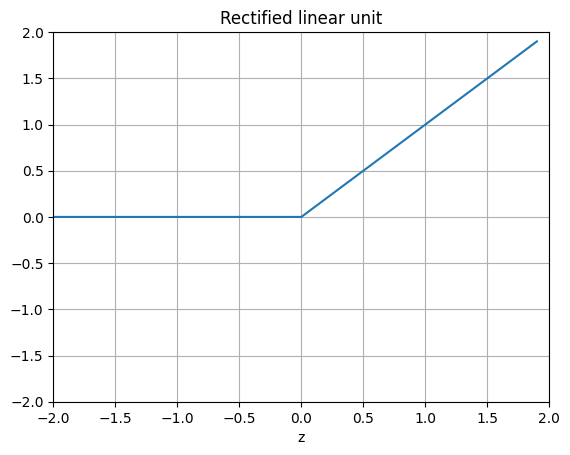

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-2, 2, .1)
zero = np.zeros(len(z))
y = np.max([zero, z], axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, y)
ax.set_ylim([-2.0, 2.0])
ax.set_xlim([-2.0, 2.0])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('Rectified linear unit')

plt.show()

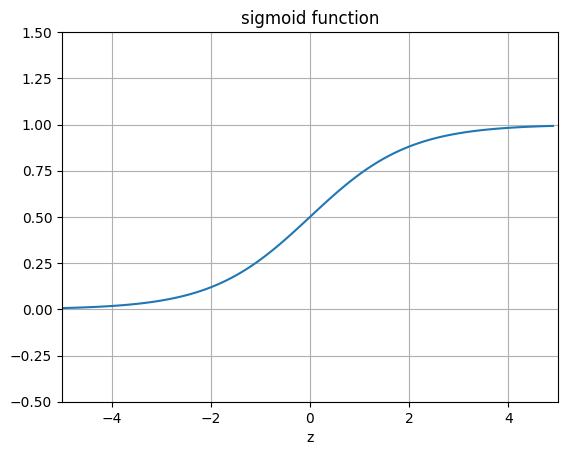

In [ ]:
z = np.arange(-5, 5, .1)
sigma_fn = np.vectorize(lambda z: 1/(1+np.exp(-z)))
sigma = sigma_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, sigma)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('sigmoid function')

plt.show()

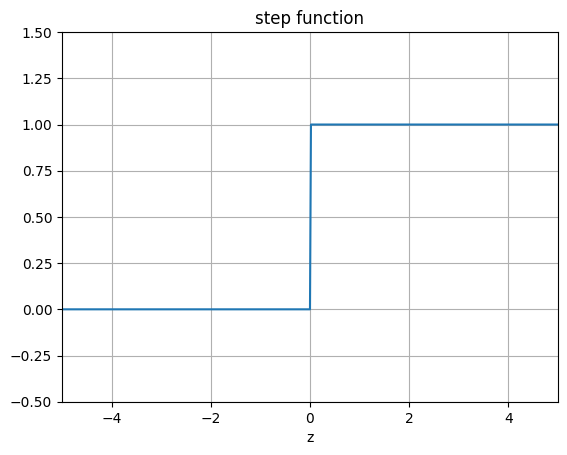

In [ ]:
z = np.arange(-5, 5, .02)
step_fn = np.vectorize(lambda z: 1.0 if z >= 0.0 else 0.0)
step = step_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, step)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('step function')

plt.show()

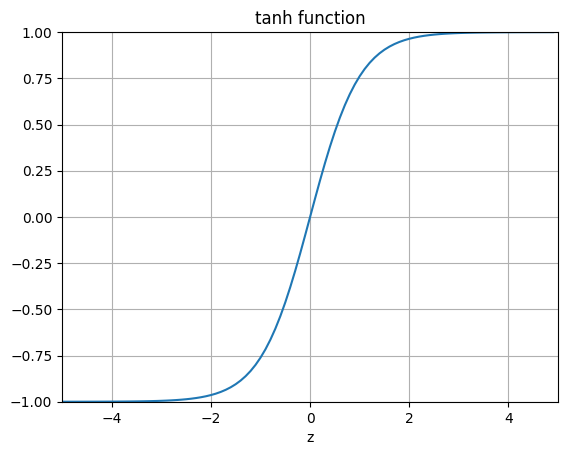

In [ ]:
z = np.arange(-5, 5, .1)
t = np.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t)
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('tanh function')

plt.show()

# Problems

---
## **Problem 1:**
- We've seen how to use networks with two hidden layers to approximate an
arbitrary function. Can you find a proof showing that it's possible with
just a single hidden layer? As a hint, try working in the case of just
two input variables, and showing that:
  1. it's possible to get step functions not just in the $x$ or $y$ directions, but in an arbitrary direction;
  2. by adding up many of the constructions from part (1) it's
  possible to approximate a tower function which is circular in shape,
  rather than rectangular;
  3. using these circular towers, it's possible
  to approximate an arbitrary function.

---
## **Answer 1:**
The task you’ve posed is closely related to the **Universal Approximation Theorem**, which states that a feedforward neural network with a single hidden layer containing a finite number of neurons can approximate any continuous function on compact subsets of $\mathbb{R}^n$, given appropriate activation functions. Here's how you can approach proving this for the case of a neural network with just one hidden layer, based on the hints provided:

### (a) Step Functions in Arbitrary Directions
Let’s first show that it is possible to get step functions not only in the $x$- or $y$-direction, but in any arbitrary direction.

A neuron with weights $w_1$ and $w_2$ and bias $b$ has the form:
$$f(x_1, x_2) = \sigma(w_1 x_1 + w_2 x_2 + b)$$ where $\sigma$ is the
activation function, such as the sigmoid or ReLU. When the input
$w_1 x_1 + w_2 x_2 + b = 0$, this defines a decision boundary in the
$(x_1, x_2)$-plane, which is a line. The step from 0 to 1 happens across
this line.

- For a step function in the $x_1$-direction, you can choose $w_2 = 0$,
and the equation reduces to $w_1 x_1 + b = 0$, i.e., a vertical line.
- For a step function in the $x_2$-direction, you can choose $w_1 = 0$,
and the equation reduces to $w_2 x_2 + b = 0$, i.e., a horizontal
line.
- For an arbitrary direction, you can vary both $w_1$ and $w_2$,
which will result in a line with slope $-w_1/w_2$. This allows us to
create step functions along any direction in the input space.

Thus, using a single hidden layer neuron with an appropriate weight
vector and bias, we can create step functions that transition from 0 to
1 across arbitrary lines in the $(x_1, x_2)$-plane.

### (b) Circular Approximation Using Step Functions
Next, we want to approximate circular shapes using these step functions.

To approximate a circle, we can sum together multiple step functions in different directions. Consider a circular region centered at the origin. We can construct step functions that approximate the boundary of this circle by forming a polygon with many sides, where each side is defined by a step function in a particular direction. As we increase the number of sides (i.e., the number of neurons), the polygon will more closely approximate the shape of a circle.

For example, by taking a set of step functions corresponding to
different angles (e.g., at $0^\circ$, $45^\circ$, $90^\circ$, etc.), we
can form a rough approximation of a circle. Increasing the number of
neurons will improve the approximation, smoothing out the circular
boundary. This is analogous to how one might approximate a smooth curve
with many small straight line segments.

Thus, by summing the outputs of many neurons with different weights, we
can construct an approximation to a circular region or \"tower\"
function.

### (c) Approximation of Arbitrary Functions Using Circular Towers
Finally, using these circular towers, we can approximate any arbitrary function.

The idea here is that any continuous function can be approximated by combining these circular regions. Think of a function that you want to approximate over some input space. You can break up the input space into small circular regions, and approximate the function value within each region by placing a tower of appropriate height (i.e., adjusting the output value) over each circular region.

This is conceptually similar to a Riemann sum approximation, where the function is approximated by a sum of small regions, each with a constant value (a "tower") inside the region. By combining enough of these towers, you can approximate the shape of any continuous function.

### Conclusion
To summarize, the proof works as follows:
1. **Step functions in arbitrary directions**: We showed that a single hidden-layer neuron can create step functions with boundaries in any direction.
2. **Approximating circular towers**: By summing step functions with boundaries in different directions, we can approximate circular regions or "towers".
3. **Approximating arbitrary functions**: Using these circular towers, we can approximate any continuous function over a compact domain.

This construction shows that even with just a single hidden layer, a neural network can approximate any continuous function, which is the essence of the Universal Approximation Theorem.

---
## **Answer 2:**

## Proof Sketch: Universal Approximation with Single Hidden Layer

### (a) Step Functions in Arbitrary Directions

1.  Consider a neuron with two inputs (`x, y`) and weights (`w1, w2`):
    `z = w1*x + w2*y + b`
2.  The activation function σ(z) creates a step along the line:
   `w1*x + w2*y + b = 0`
3.  By adjusting w1 and w2, we can create a step in any direction in the
    `x-y` plane

### (b) Approximating Circular Tower Functions

1.  Use multiple neurons from (a) to create steps in different directions
2.  Combine these steps with appropriate weights to approximate a circular boundary
3.  Use a large positive weight in the output layer to create a "tower" effect
4.  Adjust the height and radius of the tower by modifying weights and biases

### (c) Approximating Arbitrary Functions

1.  Any continuous function on a compact subset of $\mathbb{R}^2$ can be approximated by a sum of circular tower functions

2.  Use the **Stone-Weierstrass theorem**:
    -   Polynomial functions are dense in the space of continuous functions
    -   Our circular towers can approximate polynomial functions

3.  Process:
    -   Divide the input space into a grid
    -   For each grid cell, use a circular tower to approximate the
        function value
    -   Refine the grid for better approximation

4.  The universal approximation theorem extends this to higher dimensions and larger input spaces

<u>Note:</u> This proof sketch demonstrates the capability of a single hidden
layer. In practice, deeper networks often learn more efficiently and
require fewer total parameters.

---

## **Problem 2:**
-   Suppose we consider linear neurons, i.e., neurons with the
    activation function $s(z) = z$. Explain why linear neurons don't
    satisfy the conditions just given for universality. Show that such
    neurons can't be used to do universal computation.

---
## **Answer:**
Linear neurons are neurons that use a linear activation function,
meaning the activation function $s(z) = z$. In other words, the output
of a linear neuron is simply a weighted sum of its inputs. While these
neurons can perform useful computations, they do not satisfy the
conditions for **universality**---i.e., they cannot approximate
arbitrary continuous functions. Here's an explanation of why this is the
case and a proof that linear neurons cannot perform universal
computation.

## Why Linear Neurons Don't Satisfy Universality

To understand why linear neurons don't lead to universal approximation,
it's useful to revisit the conditions required for universal
computation, as seen in the **Universal Approximation Theorem**:

1. **Non-linearity**: The activation function of neurons needs to
be non-linear. This is crucial because networks composed only of linear
transformations are equivalent to a single linear transformation, no
matter how deep the network is.

2. **Expressive Power**: The network must be capable of combining
neurons in a way that allows for the approximation of any continuous
function on a compact domain.

Linear neurons fail to satisfy the non-linearity condition, which is a
core requirement for universality.

### Proof: Linear Networks Are Equivalent to a Single Linear Layer

Let's explore why a network composed of linear neurons cannot
approximate arbitrary continuous functions.

#### Single Layer of Linear Neurons

Consider a single neuron with the linear activation function $s(z) = z$.
The output of this neuron can be written as:

$$y = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b$$

where $w_1, w_2, \dots, w_n$ are the weights, $x_1, x_2, \dots, x_n$ are
the inputs, and $b$ is the bias term. This is simply a linear
combination of the inputs.

#### Stacking Multiple Layers of Linear Neurons

Now, consider a network of linear neurons with multiple layers. In the
first layer, the output is:

$$y_1 = W_1 x + b_1$$

where $W_1$ is the weight matrix, $x$ is the input vector, and $b_1$ is
the bias vector for the first layer. In the second layer, the input to
the neurons is $y_1$, and the output of the second layer is:

$$y_2 = W_2 y_1 + b_2 = W_2 (W_1 x + b_1) + b_2$$

This simplifies to:

$$y_2 = W_2 W_1 x + W_2 b_1 + b_2$$

Now, consider adding more layers. The output at the $k$-th layer can be
written as:

$$y_k = W_k (W_{k-1} \dots W_1 x + b_1) + b_k$$

Ultimately, the entire network is just a composition of linear
transformations. This means that the output of the network can always be
expressed as:

$$y = W x + b$$

where $W$ is a single weight matrix that results from multiplying the
weight matrices of each layer together, and $b$ is an aggregate bias
term. In other words, **the entire network is equivalent to a single
linear transformation**.

#### Consequence: No Increase in Expressive Power

Because the composition of linear functions is itself a linear function,
the network as a whole is still a linear model, regardless of how many
layers or neurons are used. This drastically limits the expressive power
of the network because:

- A linear function cannot represent non-linear relationships between
variables. - Many real-world functions, such as decision boundaries for
classification tasks, require non-linear mappings.

Thus, linear neurons can only model linear relationships between inputs
and outputs, and **they cannot approximate non-linear functions**.
This severely restricts the types of functions a network of linear
neurons can approximate.

### Conclusion: No Universal Computation with Linear Neurons

Because networks composed of linear neurons are equivalent to a single
linear transformation, they cannot approximate arbitrary continuous
functions. The lack of non-linearity prevents such networks from
representing complex, non-linear relationships that are essential for
universal function approximation.

In contrast, networks with non-linear activation functions, such as the
sigmoid, $\tanh$, or ReLU functions, break the linearity and allow for
the approximation of a wide range of continuous functions. This is why
non-linear activation functions are necessary for universal computation
in neural networks.

----

## **Problem 3:**
-   Earlier in the book we met another type of neuron known as a rectified
    linear unit, `ReLU`. Explain why such neurons don't satisfy the conditions just given for universality. Find a proof of universality showing that rectified linear units are universal for computation.

---
## **Answer 1:**

## ReLU Universality in Neural Networks

### Part 1: Why ReLUs Don’t Satisfy Previous Conditions

The previous proof relied on the properties of sigmoid-like activation
functions, specifically:

1.  They are bounded (output is between 0 and 1).
2.  They have a smooth, continuous transition between their minimum and
    maximum values.

Rectified Linear Units (ReLUs) differ in key ways:

1.  ReLU(x) = max(0, x)
2.  They are unbounded for positive inputs.
3.  They have a sharp transition at x = 0, not a smooth one.

These differences mean that ReLUs can’t directly create the “circular
towers” we used in the previous proof. They produce piecewise linear
functions instead of smooth, bounded ones.

### Part 2: Proof of Universality for ReLUs

Despite these differences, ReLUs are indeed universal approximators.
Here’s a sketch of the proof:

1.  **Piecewise Linear Approximation**: Any continuous function on a
    compact domain can be approximated arbitrarily closely by a
    piecewise linear function.

2.  **ReLU as a Building Block**: Consider a “hinge” function: h(x) =
    ReLU(x) - ReLU(x - 1) This creates a piecewise linear function
    that’s 0 for x \< 0, increases linearly from 0 to 1 for 0 ≤ x \< 1,
    and stays at 1 for x ≥ 1.

3.  **Constructing Arbitrary Piecewise Linear Functions**:

    1.  For a single input variable:
        -   Use multiple scaled and shifted hinge functions
        -   Example: f(x) = a₁h(b₁x + c₁) + a₂h(b₂x + c₂) + … +
            aₙh(bₙx + cₙ)
    2.  For multiple input variables:
        -   Use linear combinations of single-variable constructions
        -   Example: g(x, y) = f₁(x) + f₂(y) + f₃(ax + by + c)

4.  **Approximating Continuous Functions**:

    -   Given any continuous function and desired error ε \> 0
    -   Choose a fine enough piecewise linear approximation
    -   Construct this approximation using ReLUs as described above

5.  **Network Structure**:

    -   <u>First hidden layer:</u> Compute linear functions inside ReLUs
    -   <u>Second hidden layer:</u> Combine ReLUs to form hinge functions
    -   <u>Output layer:</u> Linear combination of hinge functions

This construction shows that a network with two hidden layers of ReLU
neurons can approximate any continuous function arbitrarily closely,
thus proving the universality of ReLU networks.

<u>Key Insight:</u> While ReLUs can’t directly create smooth, bounded functions
like sigmoids, they can create piecewise linear approximations of any
continuous function, which is sufficient for universality.

---
## **Answer 2:**
Certainly! Here's a more mathematical approach to showing the universality of ReLU networks.

### Step 1: Define the ReLU Function
The ReLU function is defined as:


$$\text{ReLU}(x) = \max(0, x)$$

This is a piecewise linear function: $$\text{ReLU}(x) =
\begin{cases}
0 & \text{if } x \leq 0 \\
x & \text{if } x > 0
\end{cases}$$

### Step 2: Universal Approximation Theorem for ReLU Networks

The **Universal Approximation Theorem** for neural networks states that, for any continuous function $f$ defined on a compact set
$K \subset \mathbb{R}^n$, there exists a neural network with at least
one hidden layer, and a sufficient number of neurons in the hidden
layer, such that the network can approximate $f$ to any desired degree
of accuracy.

For ReLU networks, this theorem holds in a similar way as for sigmoid or tanh activations. While individual ReLUs are piecewise linear, a network made up of several ReLUs is capable of approximating any continuous function.

### Step 3: Constructing a Piecewise Linear Approximation

Let’s focus on constructing the approximation. The idea behind the proof is that **any continuous function can be approximated by piecewise linear functions**, and ReLU neurons are capable of building piecewise linear functions.

To approximate a continuous function \( f(x) \) on a compact domain, we partition the domain into smaller segments, and approximate \( f(x) \) on each segment by a linear function. By adding more ReLUs, we can increase the number of segments and reduce the approximation error.

1. **Partition the Domain**:  
  Let's consider a compact interval $[a, b] \subset \mathbb{R}$. We partition this interval into $N$ sub-intervals:

  $$a = x_0 < x_1 < \cdots < x_N = b$$

  On each sub-interval $[x_i, x_{i+1}]$, we approximate $f(x)$ by a linear function. So, on $[x_i, x_{i+1}]$, we define:

  $$f(x) \approx f(x_i) + \frac{f(x_{i+1}) - f(x_i)}{x_{i+1} - x_i}(x - x_i)$$

  This is a linear approximation of $f(x)$ on each segment

2. **Using ReLU to Represent Linear Functions**:  
   ReLU networks can represent such piecewise linear functions. To see how, consider the following:

   A ReLU function can be used to create a "kink" in a linear function, where the slope changes at some point \( c \). For example:
   $$\text{ReLU}(x - c) =
   \begin{cases}
   0 & \text{if } x \leq c \\
   x - c & \text{if } x > c
   \end{cases}$$
   By combining several ReLU functions with different shifts, it's possible to construct a piecewise linear function with "kinks" at arbitrary points.

3. **Constructing a Neural Network to Approximate \( f(x) \)**:  
   To approximate \( f(x) \), we use the following strategy:

   - For each sub-interval $[x_i, x_{i+1}]$, we define a linear function
   that approximates $f(x)$ on that interval
   - These linear functions can be constructed using weighted sums of ReLU activations.

   For instance, a simple two-layer ReLU network can represent a function like:
   $$h(x) = w_1 \text{ReLU}(x - c_1) + w_2 \text{ReLU}(x - c_2) + \cdots + w_k \text{ReLU}(x - c_k)$$
   By choosing the appropriate weights $w_i$ and thresholds $c_i$, this
   function can represent any piecewise linear approximation to $f(x)$.

### Step 4: Error Bound and Universality

As the number of partitions $N$ increases, the piecewise linear
approximation becomes more accurate. Specifically, the approximation
error decreases as:

$$\max_{x \in [a, b]} | f(x) - h(x) | \to 0 \quad \text{as} \quad N \to \infty$$

This shows that by adding more ReLU neurons (increasing the complexity
of the network), we can approximate any continuous function $f(x)$ to
arbitrary precision. Since $f(x)$ is continuous and the approximation is
piecewise linear, the ReLU network can achieve universal approximation
by using enough neurons and layers.


### Step 5: Generalization to Higher Dimensions

The argument extends to higher-dimensional functions
$f: \mathbb{R}^n \to \mathbb{R}$ by approximating the function on a grid
in $\mathbb{R}^n$. In this case, the ReLU network approximates $f$ using
piecewise linear functions over the grid's regions, and the same
strategy applies to show that any continuous function on a compact
domain can be approximated.

### Conclusion

By using ReLU neurons in a neural network, we can construct piecewise linear functions that approximate any continuous function on a compact domain. The Universal Approximation Theorem applies to ReLU networks, proving that they are capable of approximating any continuous function to arbitrary precision, despite the piecewise linear nature of individual ReLU neurons. The key lies in the network's ability to combine many ReLU activations to form a flexible piecewise linear function.

---